> # Case Study : Telecom Churn Case Study

### Problem Statement

>In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

 

>For many incumbent operators, retaining high profitable customers is the number one business goal.

 

>To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

 

>In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.. 

### Business Goal 

>The business objective is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. To do this task well, understanding the typical customer behaviour during churn will be helpful.
In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

## <a id='1'>1. Importing Supporting Moduels & Libraries</a>

In [1]:
import pandas as pd
import numpy as np
import warnings

from scipy import special 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import math
from IPython.display import Markdown, display ,HTML


from sklearn.model_selection import train_test_split
import io
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

sns.set(style="whitegrid")
pd.set_option('display.max_colwidth', -1) # make sure data and columns are displayed correctly withput purge
pd.options.display.float_format = '{:20,.2f}'.format # display float value with correct precision 


warnings.filterwarnings('ignore')

## <a id='2'>2. Utility Methods</a>

In [2]:
#function  for pie plot for customer attrition types
def plot_pie(column) :
    
    trace1 = go.Pie(values  = churn[column].value_counts().values.tolist(),
                    labels  = churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    domain  = dict(x = [0,.48]),
                    name    = "Churn Customers",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    hole    = .6
                   )
    trace2 = go.Pie(values  = not_churn[column].value_counts().values.tolist(),
                    labels  = not_churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    domain  = dict(x = [.52,1]),
                    hole    = .6,
                    name    = "Non churn customers" 
                   )


    layout = go.Layout(dict(title = column + " distribution in customer attrition ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            annotations = [dict(text = "churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .15, y = .5),
                                           dict(text = "Non churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .88,y = .5
                                               )
                                          ]
                           )
                      )
    data = [trace1,trace2]
    fig  = go.Figure(data = data,layout = layout)
    py.iplot(fig)


#function  for histogram for customer attrition types
def histogram(column) :
    trace1 = go.Histogram(x  = churn[column],
                          histnorm= "percent",
                          name = "Churn Customers",
                          marker = dict(line = dict(width = .5,
                                                    color = "black"
                                                    )
                                        ),
                         opacity = .9 
                         ) 
    
    trace2 = go.Histogram(x  = not_churn[column],
                          histnorm = "percent",
                          name = "Non churn customers",
                          marker = dict(line = dict(width = .5,
                                              color = "black"
                                             )
                                 ),
                          opacity = .9
                         )
    
    data = [trace1,trace2]
    layout = go.Layout(dict(title =column + " distribution in customer attrition ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = column,
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = "percent",
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                           )
                      )
    fig  = go.Figure(data=data,layout=layout)
    
    py.iplot(fig)
    
def log(string):
    display(Markdown("> <span style='color:black'>"+string+"</span>"))

def header(string):
    display(Markdown("------ "))
    display(Markdown("### "+string))
    
def header_red(string):
    display(Markdown("> <span style='color:red'>"+string))   

def get_variable_type(element) :
    """
     Check is columns are of Contineous or Categorical variable.
     Assumption is that if 
                 unique count < 20 then categorical 
                 unique count >= 20 and dtype = [int64 or float64] then contineous
     """
    if element==0:
        return "Not Known"
    elif element < 20 and element!=0 :
        return "Categorical"
    elif element >= 20 and element!=0 :
        return "Contineous" 
    
def get_meta_data(dataframe) :
    """
     Method to get Meta-Data about any dataframe passed 
    """
    metadata_matrix = pd.DataFrame({
                    'Datatype' : dataframe.dtypes.astype(str), 
                    'Non_Null_Count': dataframe.count(axis = 0).astype(int), 
                    'Null_Count': dataframe.isnull().sum().astype(int), 
                    'Null_Percentage': dataframe.isnull().sum()/len(dataframe) * 100, 
                    'Unique_Values_Count': dataframe.nunique().astype(int) 
                     })
    
    metadata_matrix = predict_variable_type(metadata_matrix)
    return metadata_matrix
        
def display_columns_with_1_unique_value(dataframe):
    unique_values_count_1 = dataframe[dataframe["Unique_Values_Count"] == 1]
    drop_value_col = unique_values_count_1.index.tolist()
    lenght = len(drop_value_col)
    header("Columns with only one unique value : "+str(lenght))
    if lenght == 0 :
        header_red("No columns with only one unique values.")  
    else :    
        log("Columns with only one unique value :")
        for index,item in enumerate(drop_value_col) :
            print(index,".",item)
            
def predict_variable_type(metadata_matrix):
    metadata_matrix["Variable_Type"] = metadata_matrix["Unique_Values_Count"].apply(get_variable_type).astype(str)
    metadata_matrix["frequency"] = metadata_matrix["Null_Count"] - metadata_matrix["Null_Count"]
    metadata_matrix["frequency"].astype(int)
    return metadata_matrix 


def list_potential_categorical_type(dataframe,main) :
    header("Stats for potential Categorical datatype columns")
    metadata_matrix_categorical = dataframe[dataframe["Variable_Type"] == "Categorical"]
    # TO DO *** Add check to skip below if there is no Categorical values 
    length = len(metadata_matrix_categorical)
    if length == 0 :
        header_red("No Categorical columns in given dataset.")  
    else :    
        metadata_matrix_categorical = metadata_matrix_categorical.filter(["Datatype","Unique_Values_Count"])
        metadata_matrix_categorical.sort_values(["Unique_Values_Count"], axis=0,ascending=False, inplace=True)
        col_to_check = metadata_matrix_categorical.index.tolist()
        name_list = []
        values_list = []
        for name in col_to_check :
            name_list.append(name)
            values_list.append(main[name].unique())
        temp = pd.DataFrame({"index":name_list,"Unique_Values":values_list})
        metadata_matrix_categorical = metadata_matrix_categorical.reset_index()
        metadata_matrix_categorical = pd.merge(metadata_matrix_categorical,temp,how='inner',on='index')
        display(metadata_matrix_categorical.set_index("index")) 

def plot_data_type_pie_chat(dataframe) : 
        header("Stats for Datatype Percentage Distribution")
        dataframe_group = dataframe.groupby("Datatype").frequency.count().reset_index()
        dataframe_group.sort_values(["Datatype"], axis=0,ascending=False, inplace=True)
        trace = go.Pie(labels=dataframe_group["Datatype"].tolist(), values=dataframe_group["frequency"].tolist())
        layout = go.Layout(title="Datatype Percentage Distribution")
        fig = go.Figure(data=[trace], layout=layout)    
        py.offline.iplot(fig)
    
def get_potential_categorical_type(dataframe,main,unique_count) :
    metadata_matrix_categorical = dataframe[dataframe["Variable_Type"] == "Categorical"]
    metadata_matrix_categorical = dataframe[dataframe["Unique_Values_Count"] == unique_count]
    length = len(metadata_matrix_categorical)
    if length == 0 :
        header_red("No Categorical columns in given dataset.")  
    else :    
        metadata_matrix_categorical = metadata_matrix_categorical.filter(["Datatype","Unique_Values_Count"])
        metadata_matrix_categorical.sort_values(["Unique_Values_Count"], axis=0,ascending=False, inplace=True)
        col_to_check = metadata_matrix_categorical.index.tolist()
        name_list = []
        values_list = []
        for name in col_to_check :
            name_list.append(name)
            values_list.append(main[name].unique())
        temp = pd.DataFrame({"index":name_list,"Unique_Values":values_list})
        metadata_matrix_categorical = metadata_matrix_categorical.reset_index()
        metadata_matrix_categorical = pd.merge(metadata_matrix_categorical,temp,how='inner',on='index')
        display(metadata_matrix_categorical.set_index("index")) 
           
def color_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for value 
    greater than 10 , black otherwise.
    """
    color = 'red' if val > 5 else 'black'
    return 'color: %s' % color

def heatmap(x,y,dataframe):
    plt.figure(figsize=(x,y)) 
    ax = sns.heatmap(dataframe.corr(), cmap="YlGnBu", annot=True) #notation: "annot" not "annote"
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()



## <a id='3'>3. Loading dataset for telecom chrun analysis</a>

In [3]:
tel_churn_df = pd.read_csv("telecom_churn_data.csv")
tel_churn_df.head(5)

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.38,214.82,213.80,21.10,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,0.00,0.00,0.00,0.00,nan,nan,0.16,nan,nan,nan,4.13,nan,nan,nan,1.15,nan,nan,nan,5.44,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,0.00,0.00,5.44,0.00,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,na

# <a id='4'>4. Data preprocessing</a>

In [4]:
print ("Rows     : " ,tel_churn_df.shape[0])
print ("Columns  : " ,tel_churn_df.shape[1])
print ("\nFeatures : \n" ,tel_churn_df.columns.tolist())
print ("\nMissing values :  ", tel_churn_df.isnull().sum().values.sum())
print ("\nUnique values :  \n",tel_churn_df.nunique())

Rows     :  99999
Columns  :  226

Features : 
 ['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'last_date_of_month_9', 'arpu_6', 'arpu_7', 'arpu_8', 'arpu_9', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'onnet_mou_9', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'offnet_mou_9', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_ic_mou_9', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'roam_og_mou_9', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_t2c_mou_9', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'loc_og_mou_9', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2t_mou_9', 'std_og

> **In churn prediction, we assume that there are three phases of customer lifecycle :**
- The ‘good’ phase [Month 6 & 7]
- The ‘action’ phase [Month 8]
- The ‘churn’ phase [Month 9]

> In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.

### <a id='4.1'>4.1.Deriving new features</a>

In [5]:
# Let us first extract list of columns containing recharge amount
recharge_amount_cols =  tel_churn_df.columns[tel_churn_df.columns.str.contains('rech_amt|rech_data')]
print(recharge_amount_cols)

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_rech_amt_9', 'max_rech_amt_6', 'max_rech_amt_7',
       'max_rech_amt_8', 'max_rech_amt_9', 'date_of_last_rech_data_6',
       'date_of_last_rech_data_7', 'date_of_last_rech_data_8',
       'date_of_last_rech_data_9', 'total_rech_data_6', 'total_rech_data_7',
       'total_rech_data_8', 'total_rech_data_9', 'max_rech_data_6',
       'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9',
       'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8',
       'av_rech_amt_data_9'],
      dtype='object')


> <span style='color:blue'>**Analysis: From above features we can derive more meaningful information :**
* Total recharge amount
* Total recharge for data
* Maximum recharge amount 
* Last date of Recharging the data
* Average recharge amount for data.
* Maximum recharge for data</span>

In [6]:
# Checking missing values percentages
tel_churn_df_null_check = 100*tel_churn_df.loc[:,recharge_amount_cols].isnull().sum()/len(tel_churn_df)
df = pd.DataFrame(tel_churn_df_null_check)
df.rename(columns={0:'Null_Percentage'}, inplace=True)
df = pd.DataFrame(df.Null_Percentage).style.applymap(color_red)
display(df)

,Null_Percentage
total_rech_amt_6,0
total_rech_amt_7,0
total_rech_amt_8,0
total_rech_amt_9,0
max_rech_amt_6,0
max_rech_amt_7,0
max_rech_amt_8,0
max_rech_amt_9,0
date_of_last_rech_data_6,74.8467
date_of_last_rech_data_7,74.4287


> <span style='color:blue'>**Analysis:** 
- We can see more then **70%** values for **recharge** related data are missing.</span>

In [7]:
tel_churn_df.loc[:,recharge_amount_cols].describe()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9
count,"99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","25,153.00","25,571.00","26,339.00","25,922.00","25,153.00","25,571.00","26,339.00","25,922.00","25,153.00","25,571.00","26,339.00","25,922.00"
mean,327.51,322.96,324.16,303.35,104.64,104.75,107.73,101.94,2.46,2.67,2.65,2.44,126.39,126.73,125.72,124.94,192.60,200.98,197.53,192.73
std,398.02,408.11,416.54,404.59,120.61,124.52,126.90,125.38,2.79,3.03,3.07,2.52,108.48,109.77,109.44,111.36,192.65,196.79,191.30,188.40
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.50,0.50,1.00
25%,109.00,100.00,90.00,52.00,30.00,30.00,30.00,28.00,1.00,1.00,1.00,1.00,25.00,25.00,25.00,25.00,82.00,92.00,87.00,69.00
50%,230.00,220.00,225.00,200.00,110.00,110.00,98.00,61.00,1.00,1.00,1.00,2.00,145.00,145.00,145.00,145.00,154.00,154.00,154.00,164.00
75%,437.50,428.00,434.50,415.00,120.00,128.00,144.00,144.00,3.00,3.00,3.00,3.00,177.00,177.00,179.00,179.00,252.00,252.00,252.00,252.00
max,"35,190.00","40,335.00","45,320.00","37,235.00","4,010.00","4,010.00","4,449.00","3,399.00",61.00,54.00,60.00,84.00,"1,555.00","1,555.00","1,555.00","1,555.00","7,546.00","4,365.00","4,076.00","4,061.00"


> <span style='color:blue'>**Analysis:**
-    We can create new feature as **total_rech_amt_data** using **total_rech_data** and **av_rech_amt_data** to capture amount utilized by customer for data.

> <span style='color:blue'>**Analysis:** 
-    Also as the minimum value is 1 we can impute the NA values by 0, Considering there were no recharges done by the customer.</span>

#### Treating NAN values in total_rech_data

In [8]:
tel_churn_df['total_rech_data_6'] = tel_churn_df['total_rech_data_6'].replace(np.NaN,0.0)
tel_churn_df['total_rech_data_7'] = tel_churn_df['total_rech_data_7'].replace(np.NaN,0.0)
tel_churn_df['total_rech_data_8'] = tel_churn_df['total_rech_data_8'].replace(np.NaN,0.0)


#### Treating NAN values in av_rech_amt_data

In [9]:
tel_churn_df['av_rech_amt_data_6'] = tel_churn_df['av_rech_amt_data_6'].replace(np.NaN,0.0)
tel_churn_df['av_rech_amt_data_7'] = tel_churn_df['av_rech_amt_data_7'].replace(np.NaN,0.0)
tel_churn_df['av_rech_amt_data_8'] = tel_churn_df['av_rech_amt_data_8'].replace(np.NaN,0.0)

#### Treating NAN values in total_rech_amt_data

In [10]:
# let's adding new column total recharge amount for data: total_rech_amt_data for calculating High Value customer process
tel_churn_df['total_rech_amt_data_6'] = tel_churn_df.av_rech_amt_data_6 * tel_churn_df.total_rech_data_6
tel_churn_df['total_rech_amt_data_7'] = tel_churn_df.av_rech_amt_data_7 * tel_churn_df.total_rech_data_7
tel_churn_df['total_rech_amt_data_8'] = tel_churn_df.av_rech_amt_data_8 * tel_churn_df.total_rech_data_8

> <span style='color:blue'>**Analysis:** 
- Defining total average recharge amount for good phase for months 6 and 7 (the good phase)</span>

In [11]:
tel_churn_df['total_avg_rech_amnt_6_7_GPhase'] = (tel_churn_df.total_rech_amt_6 + tel_churn_df.total_rech_amt_data_6 \
                                               + tel_churn_df.total_rech_amt_7+ tel_churn_df.total_rech_amt_data_7)/2

### <a id='4.2'>4.2. Filter high-value customers</a>

> **Define high-value customers as follows:**
- Those who have recharged with an amount more than or equal to X, where X is greater than 70th percentile of the average recharge amount in the first two months (the good phase)

In [12]:
# create a filter for values greater than 70th percentile of total average recharge amount for good phase 
high_value_filter = tel_churn_df.total_avg_rech_amnt_6_7_GPhase.quantile(0.7)

log('70 percentile of 6th and 7th months avg recharge amount: '+str(high_value_filter))

telecom_df_high_val_cust = tel_churn_df[tel_churn_df.total_avg_rech_amnt_6_7_GPhase > high_value_filter]
log('Dataframe Shape after Filtering High Value Customers: ' + str(telecom_df_high_val_cust.shape))

> <span style='color:black'>70 percentile of 6th and 7th months avg recharge amount: 478.0</span>

> <span style='color:black'>Dataframe Shape after Filtering High Value Customers: (29953, 230)</span>

### <a id='4.3'>4.3. Tag churners and remove attributes of the churn phase</a>

> Tag churners and remove attributes of the churn phase
- Now tag the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. 
- The attributes you need to use to tag churners are:**total_ic_mou_9, total_og_mou_9, vol_2g_mb_9, vol_3g_mb_9**
- After tagging churners, remove all the attributes corresponding to the churn phase (all attributes having ‘ _9’, etc. in their names).

In [13]:
high_val_cust_9 = ['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9','vol_3g_mb_9']

In [14]:
# Checking the NA/Null values are present or Not
df = 100*telecom_df_high_val_cust.loc[:,high_val_cust_9].isnull().sum()/len(telecom_df_high_val_cust)
df = pd.DataFrame(df)
df.rename(columns={0:'Null_Percentage'}, inplace=True)
df = pd.DataFrame(df.Null_Percentage).style.applymap(color_red)
display(df)

,Null_Percentage
total_ic_mou_9,0
total_og_mou_9,0
vol_2g_mb_9,0
vol_3g_mb_9,0


In [15]:
# Initially set all the values as 0
telecom_df_high_val_cust['churn']= 0

In [16]:
#is_churned boolean flag for customers where above values are zero
is_churned = (telecom_df_high_val_cust.total_ic_mou_9 == 0) & \
             (telecom_df_high_val_cust.total_og_mou_9 == 0) & \
             (telecom_df_high_val_cust.vol_2g_mb_9 ==0) & \
             (telecom_df_high_val_cust.vol_3g_mb_9 ==0)

In [17]:
# set all which having is_churned True condition as 1
telecom_df_high_val_cust.loc[is_churned,'churn']=1

In [18]:
# let us check what's the % of churned customers
100*telecom_df_high_val_cust.churn.sum()/len(telecom_df_high_val_cust)

8.122725603445398

After tagging churners, remove all the attributes corresponding to the churn phase **(all attributes having ‘ _9’, etc. in their names)**

In [19]:
churn_month_columns =  telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('_9')]

In [20]:
# drop all columns corresponding to the churn phase
telecom_df_high_val_cust.drop(churn_month_columns,axis=1,inplace=True)

# EDA

### 1. Preprocess data (convert columns to appropriate formats, handle missing values, etc.)

In [21]:
list_potential_categorical_type(get_meta_data(telecom_df_high_val_cust),telecom_df_high_val_cust)

------ 

### Stats for potential Categorical datatype columns

,Datatype,Unique_Values_Count,Unique_Values
index,,,
monthly_3g_7,int64,15,"[1, 0, 2, 5, 3, 8, 4, 7, 6, 9, 11, 12, 14, 10, 16]"
monthly_3g_8,int64,12,"[1, 0, 2, 7, 3, 4, 6, 5, 8, 10, 9, 16]"
monthly_3g_6,int64,12,"[1, 0, 4, 2, 3, 5, 7, 6, 9, 8, 11, 14]"
monthly_2g_8,int64,6,"[0, 1, 2, 5, 3, 4]"
monthly_2g_7,int64,6,"[0, 1, 2, 5, 4, 3]"
monthly_2g_6,int64,5,"[0, 2, 1, 3, 4]"
night_pck_user_6,float64,2,"[0.0, nan, 1.0]"
night_pck_user_7,float64,2,"[0.0, nan, 1.0]"
fb_user_8,float64,2,"[1.0, nan, 0.0]"


> <span style='color:blue'>**Analysis:** 
-    Dropping above features with only **one unique** value as they will not add any value to our model building and analyis</span>

In [22]:
drop_col_with_unique_col =['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 
                          'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 
                          'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 
                          'std_og_t2c_mou_8',  'std_ic_t2o_mou_6', 
                          'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']

In [23]:
log("Features before dropping unique values : "+ str(telecom_df_high_val_cust.shape[1]))
telecom_df_high_val_cust.drop(drop_col_with_unique_col,axis=1,inplace=True)
log("Features after dropping unique values : "+ str(telecom_df_high_val_cust.shape[1]))

> <span style='color:black'>Features before dropping unique values : 177</span>

> <span style='color:black'>Features after dropping unique values : 164</span>

In [24]:
meta_df = get_meta_data(telecom_df_high_val_cust)

> **Exploring Date field**

In [25]:
meta_df_count = meta_df[meta_df["Datatype"] == 'object']
date_col = meta_df_count.index.tolist()
date_col

['date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8']

In [26]:
telecom_df_high_val_cust[date_col].head(5)

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8
0,6/21/2014,7/16/2014,8/8/2014,6/21/2014,7/16/2014,8/8/2014
7,6/27/2014,7/25/2014,8/26/2014,NaN,NaN,NaN
8,6/25/2014,7/31/2014,8/30/2014,NaN,7/31/2014,8/23/2014
21,6/30/2014,7/31/2014,8/31/2014,NaN,NaN,NaN
23,6/18/2014,7/7/2014,8/24/2014,NaN,7/7/2014,8/6/2014


In [27]:
for col in date_col:
    telecom_df_high_val_cust[col] = pd.to_datetime(telecom_df_high_val_cust[col])

In [28]:
telecom_df_high_val_cust[date_col].head(5)

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8
0,2014-06-21,2014-07-16,2014-08-08,2014-06-21,2014-07-16,2014-08-08
7,2014-06-27,2014-07-25,2014-08-26,NaT,NaT,NaT
8,2014-06-25,2014-07-31,2014-08-30,NaT,2014-07-31,2014-08-23
21,2014-06-30,2014-07-31,2014-08-31,NaT,NaT,NaT
23,2014-06-18,2014-07-07,2014-08-24,NaT,2014-07-07,2014-08-06


In [29]:
telecom_df_high_val_cust.head(8)

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,total_avg_rech_amnt_6_7_GPhase,churn
0,7000842753,197.38,214.82,213.80,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,0.00,0.00,0.00,nan,nan,0.16,nan,nan,4.13,nan,nan,1.15,nan,nan,5.44,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,0.00,0.00,5.44,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,4,3,2,362,252,252,252,252,252,2014-06-21,2014-07-16,2014-08-08,252,252,252,2014-06-21,2014-07-16,2014-08-08,1.00,1.00,1.00,252.00,252.00,252.00,0.00,0.00,0.00,1.00,1.00,1.00,252.00,252.00,252.00,30.13,1.32,5.75,83.57,150.76,109.61,212.17,212.17,212.17,212.17,212.17,212.17,0.00,0.00,0.00,0,0,0,0,0,0,1,1,1,0,0,0,1.00,1.00,1.00,968,30.40,0.00,101.20,3.58,252.00,252.00,252.00,559.00,1
7,7000701601,"1,069.18","1,349.85","3,171.48",57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.00,0.00,0.00,422.16,533.91,255.79,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,60.86,75.14,77.84,0.00,0.18,10.01,4.50,0.00,6.50,0.00,0.00,0.00,487.53,609.24,350.16,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,427.88,355.23,188.04,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,180.54,173.08,193.94,626.46,558.04,428.74,0.21,0.00,0.00,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,3638,1580,790,1580,2014-06-27,2014-07-25,2014-08-26,0,0,779,NaT,NaT,NaT,0.00,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00

In [30]:
list_potential_categorical_type(get_meta_data(telecom_df_high_val_cust),telecom_df_high_val_cust)

------ 

### Stats for potential Categorical datatype columns

,Datatype,Unique_Values_Count,Unique_Values
index,,,
monthly_3g_7,int64,15,"[1, 0, 2, 5, 3, 8, 4, 7, 6, 9, 11, 12, 14, 10, 16]"
monthly_3g_6,int64,12,"[1, 0, 4, 2, 3, 5, 7, 6, 9, 8, 11, 14]"
monthly_3g_8,int64,12,"[1, 0, 2, 7, 3, 4, 6, 5, 8, 10, 9, 16]"
monthly_2g_7,int64,6,"[0, 1, 2, 5, 4, 3]"
monthly_2g_8,int64,6,"[0, 1, 2, 5, 3, 4]"
monthly_2g_6,int64,5,"[0, 2, 1, 3, 4]"
night_pck_user_6,float64,2,"[0.0, nan, 1.0]"
night_pck_user_7,float64,2,"[0.0, nan, 1.0]"
night_pck_user_8,float64,2,"[0.0, nan, 1.0]"


### 2. Conduct appropriate exploratory analysis to extract useful insights (whether directly useful for business or for eventual modelling/feature engineering).

In [31]:
# create box plot for  6th, 7th and 8th month
def plot_box_chart(attribute):
    plt.figure(figsize=(20,16))
    df = telecom_df_high_val_cust
    plt.subplot(2,3,1)
    sns.boxplot(data=df, y=attribute+"_6",x="churn",hue="churn",
                showfliers=False,palette=("Blues"))
    plt.subplot(2,3,2)
    sns.boxplot(data=df, y=attribute+"_7",x="churn",hue="churn",
                showfliers=False,palette=("Blues"))
    plt.subplot(2,3,3)
    sns.boxplot(data=df, y=attribute+"_8",x="churn",hue="churn",
                showfliers=False,palette=("Blues"))
    plt.show()

### a. Recharge amount related variables
------

In [32]:
recharge_amnt_columns =  telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('rech_amt')]
recharge_amnt_columns.tolist()

['total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'total_rech_amt_data_6',
 'total_rech_amt_data_7',
 'total_rech_amt_data_8']

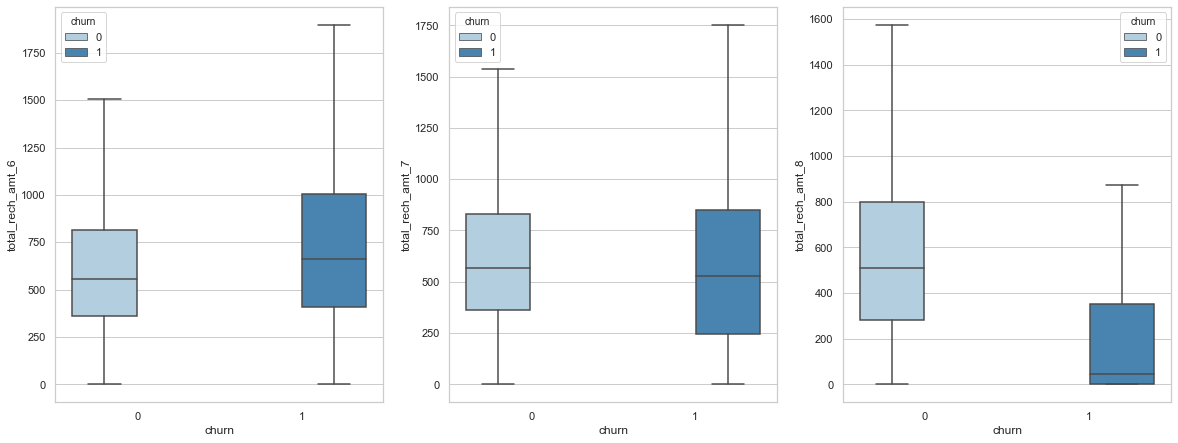

In [33]:
# Ploting for total recharge amount:
plot_box_chart('total_rech_amt')

**> <span style='color:blue'>**Analysis:** We can see a drop in the total recharge amount for churned customers in the 8th Month (Action Phase).

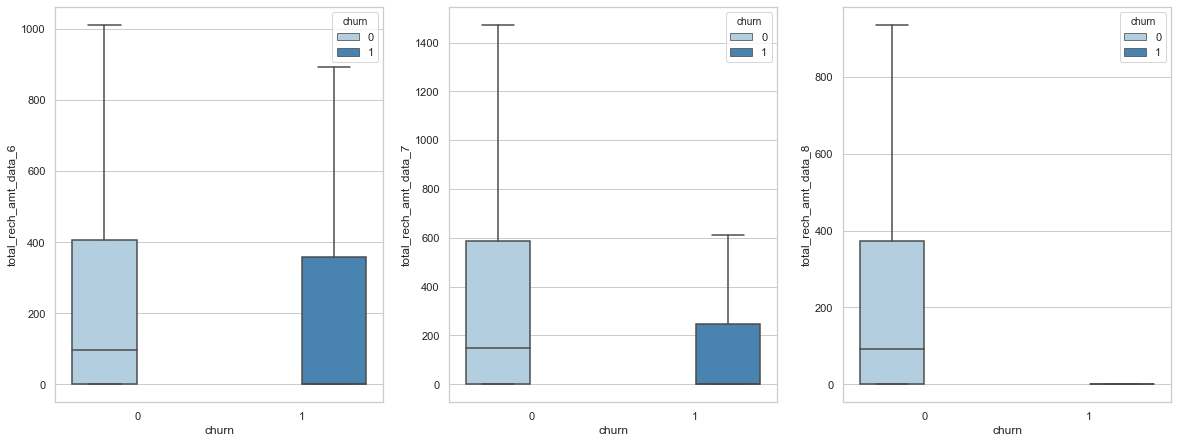

In [34]:
# Ploting for total recharge amount for data:
plot_box_chart('total_rech_amt_data')

**> <span style='color:blue'>**Analysis:** We can see that there is a huge drop in total recharge amount for data in the 8th month (action phase) for churned customers.

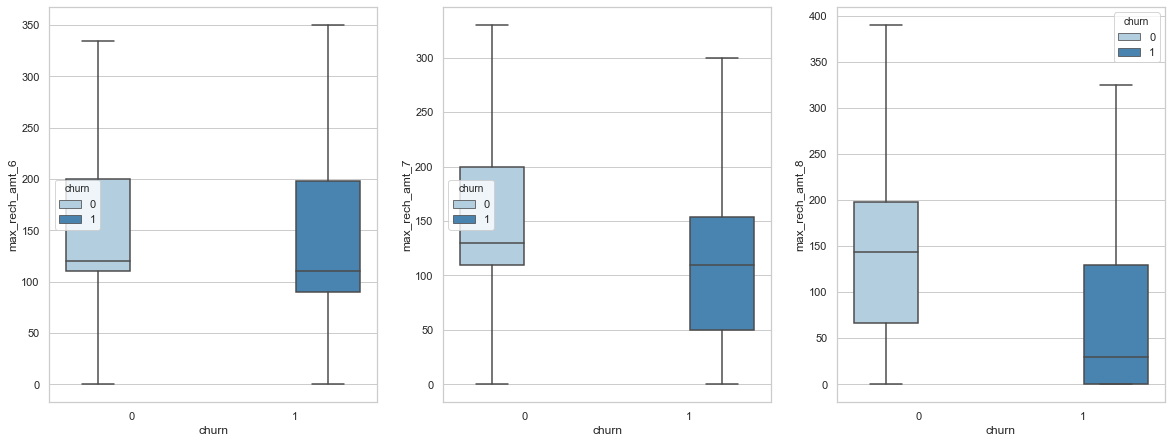

In [35]:
# Ploting for maximum recharge amount for data:
plot_box_chart('max_rech_amt')

> <span style='color:blue'>**Analysis:** 
    We can see that there is a huge drop in maximum recharge amount for data in the 8th month (action phase) for churned customers.

In [36]:
# Let's check other recharge related variables:
other_recharge = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('rech_num|max_rech_data',regex=True)]


In [37]:
# lets check the % of NA values for other recharge related variables
100*telecom_df_high_val_cust.loc[:,other_recharge].isnull().sum()/len(telecom_df_high_val_cust)

total_rech_num_6                   0.00
total_rech_num_7                   0.00
total_rech_num_8                   0.00
max_rech_data_6                   44.11
max_rech_data_7                   43.12
max_rech_data_8                   46.80
dtype: float64

In [38]:
telecom_df_high_val_cust.loc[:,['max_rech_data_6','max_rech_data_7','max_rech_data_8']].describe()

,max_rech_data_6,max_rech_data_7,max_rech_data_8
count,"16,740.00","17,038.00","15,935.00"
mean,139.80,140.44,136.35
std,118.89,120.30,119.57
min,1.00,1.00,1.00
25%,25.00,25.00,25.00
50%,152.00,152.00,152.00
75%,198.00,198.00,198.00
max,"1,555.00","1,555.00","1,555.00"


> <span style='color:blue'>**Analysis:** We see that the minimum value is 1 while the max is 1555 across months, which indicate the missing values are where no recharges happened for the data, Filling the missing values by 0 , means no recharge.

In [39]:
telecom_df_high_val_cust.loc[:,['max_rech_data_6','max_rech_data_7','max_rech_data_8']] \
= telecom_df_high_val_cust.loc[:,['max_rech_data_6','max_rech_data_7','max_rech_data_8']].replace(np.nan,0)

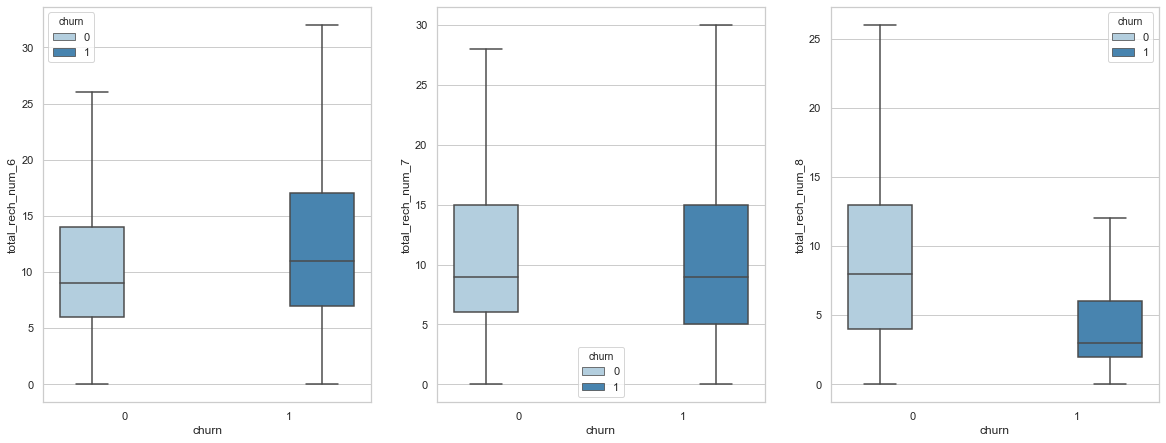

In [40]:
# Ploting for Total recharge for Number:
plot_box_chart('total_rech_num')

> <span style='color:blue'>**Analysis:** We can see that there is a huge drop in total recharge number also in the 8th month (action phase) for churned customers.

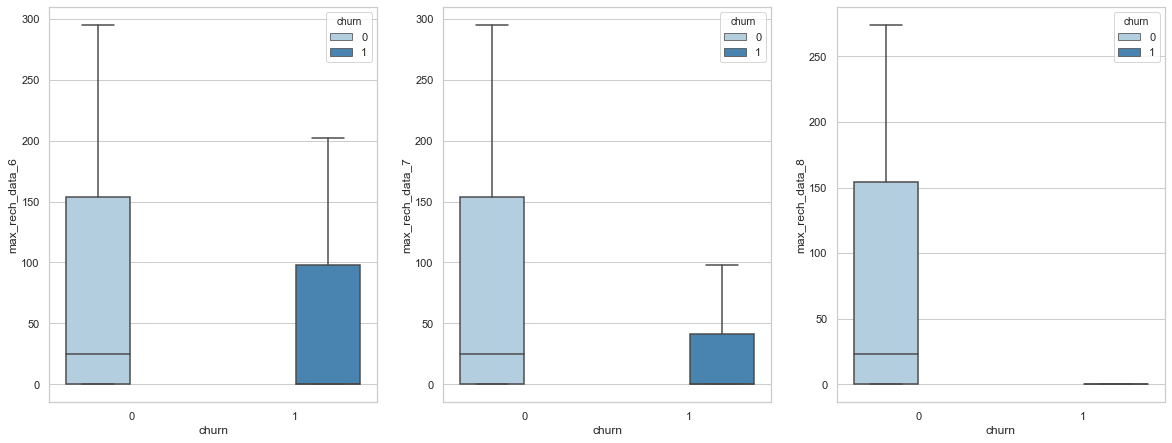

In [41]:
# Ploting for maximum recharge for data:
plot_box_chart('max_rech_data')

> <span style='color:blue'>**Analysis:** We can see that there is a huge drop in maximum recharge for data also in the 8th month (action phase) for churned customers.

In [42]:
#Getting the last day recharge amount columns
last_day_rech_amt = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('day')]

In [43]:
last_day_rech_amt.tolist()

['last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8']

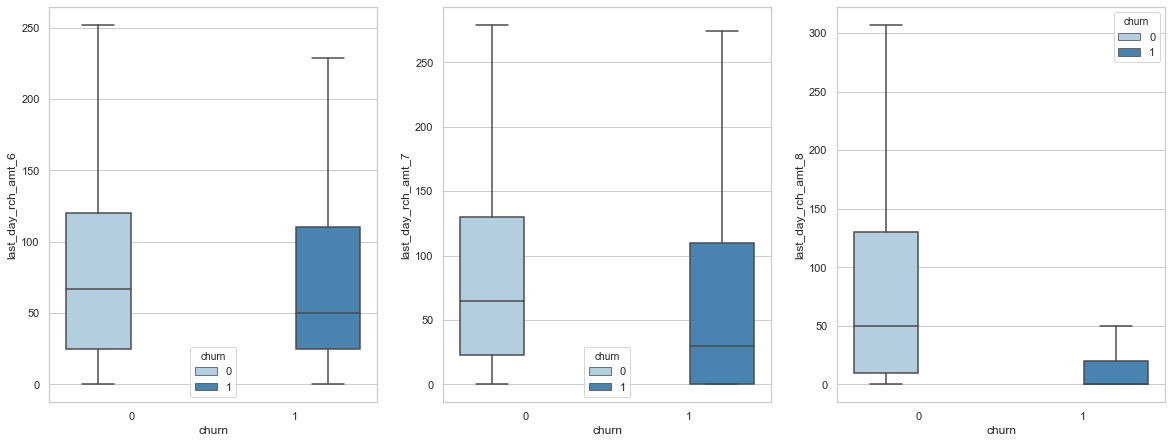

In [44]:
# Ploting for last day recharge amount:
plot_box_chart('last_day_rch_amt')

> <span style='color:blue'>**Analysis:** We are getting a huge drop in 8th month recharge amount for churned customers.

#### b. 2G and 3G usage related attributes

In [45]:
usage_2g_and_3g = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('2g|3g',regex=True)]

In [46]:
#let us check the % of NA values present
percentage_3g_2g_null_check = 100*telecom_df_high_val_cust.loc[:,usage_2g_and_3g].isnull().sum()/len(telecom_df_high_val_cust.loc[:,usage_2g_and_3g])
df = pd.DataFrame(percentage_3g_2g_null_check)
df.rename(columns={0:'Null_Percentage'}, inplace=True)
df = pd.DataFrame(df.Null_Percentage).style.applymap(color_red)
display(df)

,Null_Percentage
count_rech_2g_6,44.1124
count_rech_2g_7,43.1176
count_rech_2g_8,46.8
count_rech_3g_6,44.1124
count_rech_3g_7,43.1176
count_rech_3g_8,46.8
vol_2g_mb_6,0
vol_2g_mb_7,0
vol_2g_mb_8,0
vol_3g_mb_6,0


> <span style='color:blue'>**Analysis:** 
-    We are getting more then 40% values are not available for count of recharge and average revenue for 2G/3G per user. 
Although we have 2G/3G volume usage based data available, we can drop these columns.

In [47]:
telecom_df_high_val_cust.drop(['count_rech_2g_6','count_rech_2g_7',
              'count_rech_2g_8','count_rech_3g_6','count_rech_3g_7','count_rech_3g_8'
               ,'arpu_3g_6','arpu_3g_7','arpu_3g_8','arpu_2g_6','arpu_2g_7','arpu_2g_8'],axis=1,inplace=True)

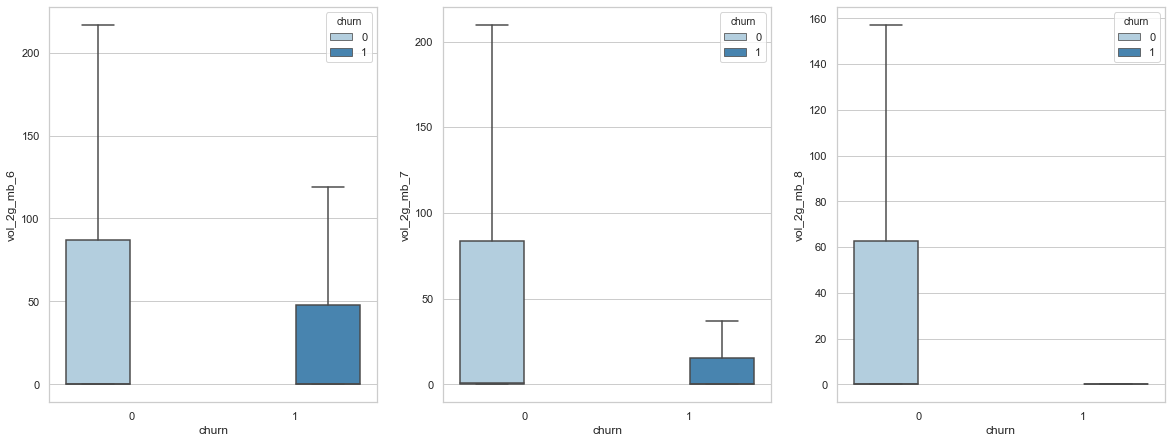

In [48]:
# Ploting for volume of 2G and 3G usage columns:
plot_box_chart('vol_2g_mb')

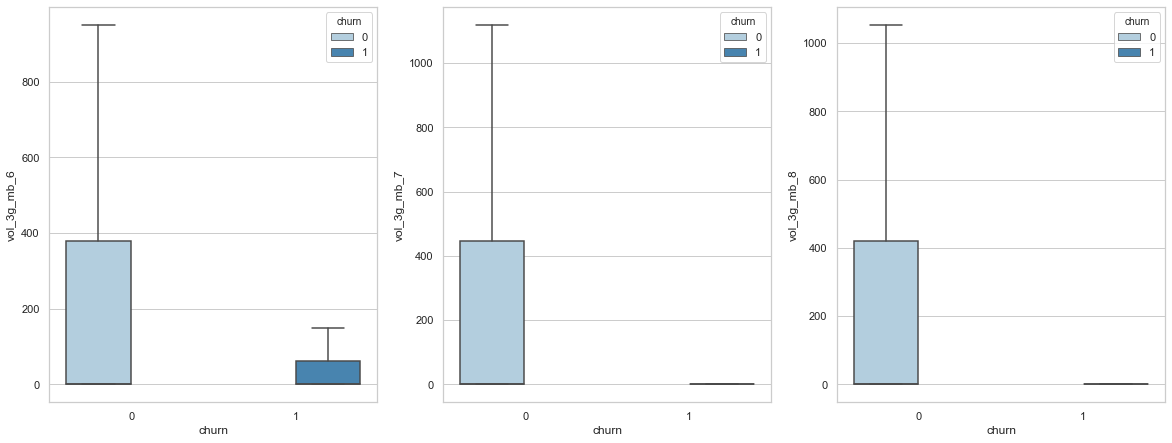

In [49]:
plot_box_chart('vol_3g_mb')

> <span style='color:blue'>**Analysis:**
- We have two observations from above: <br> 1) 2G and 3G usage for churned customers drops in 8th month<br>
2) We also see that 2G/3G usage is higher for non-churned customers indicating that churned customers might be from areas where 2G/3G service is not properly available.</span>

In [50]:
# let's check monthly 2G/3G service schemes
monthly_subcription_2g_3g = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('monthly_2g|monthly_3g',regex=True)]
monthly_subcription_2g_3g.tolist()

['monthly_2g_6',
 'monthly_2g_7',
 'monthly_2g_8',
 'monthly_3g_6',
 'monthly_3g_7',
 'monthly_3g_8']

In [51]:
#Checking Null value
#100*telecom_df_high_val_cust.loc[:,monthly_subcription_2g_3g].isnull().sum()/len(telecom_df_high_val_cust.loc[:,monthly_subcription_2g_3g])

In [52]:
telecom_df_high_val_cust[monthly_subcription_2g_3g].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29953 entries, 0 to 99997
Data columns (total 6 columns):
monthly_2g_6    29953 non-null int64
monthly_2g_7    29953 non-null int64
monthly_2g_8    29953 non-null int64
monthly_3g_6    29953 non-null int64
monthly_3g_7    29953 non-null int64
monthly_3g_8    29953 non-null int64
dtypes: int64(6)
memory usage: 2.8 MB


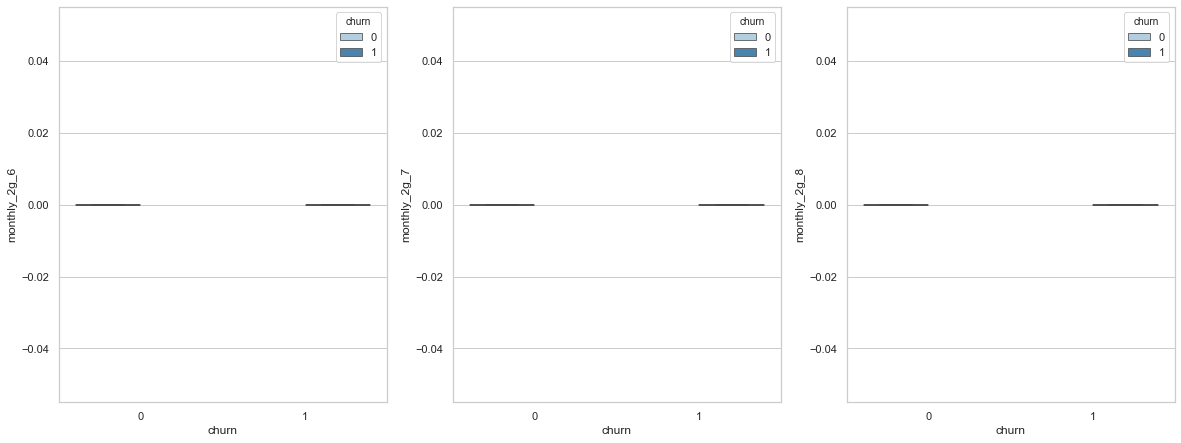

In [53]:
# Ploting for monthly subscription :
plot_box_chart('monthly_2g')


> <span style='color:blue'>**Analysis:** 
-    Value range is very low, hence graph is not giving us proper justification result .Hence doing analysis by checking mean value.

In [54]:
def plot_mean_bar_chart(df,columns_list):
    df_0 = df[df.churn==0].filter(columns_list)
    df_1 = df[df.churn==1].filter(columns_list)

    mean_df_0 = pd.DataFrame([df_0.mean()],index={'Non Churn'})
    mean_df_1 = pd.DataFrame([df_1.mean()],index={'Churn'})

    frames = [mean_df_0, mean_df_1]
    mean_bar = pd.concat(frames)

    mean_bar.T.plot.bar(figsize=(10,5),rot=0)
    plt.show()
    
    return mean_bar

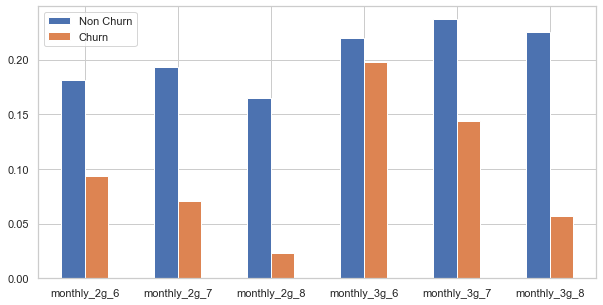

,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8
Non Churn,0.18,0.19,0.17,0.22,0.24,0.22
Churn,0.09,0.07,0.02,0.20,0.14,0.06


In [55]:
plot_mean_bar_chart(telecom_df_high_val_cust, monthly_subcription_2g_3g)


> <span style='color:blue'>**Analysis:**
-    Again we can see a drop in monthly subscription for churned customers in 8th Month.

In [56]:
# let's check Volume based cost 
vbc_column = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('vbc_',regex=True)]
vbc_column.tolist()

['aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g']

In [57]:
# Renaming month named vbc columns to 6,7,8,9 format
telecom_df_high_val_cust.rename(columns={'jun_vbc_3g':'vbc_3g_6','jul_vbc_3g':'vbc_3g_7','aug_vbc_3g':'vbc_3g_8'
                         ,'sep_vbc_3g':'vbc_3g_9'}, inplace=True)

# drop 9th month column as it is not needed
telecom_df_high_val_cust.drop('vbc_3g_9',axis=1,inplace=True)

In [58]:
vbc_column = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('vbc_3g',regex=True)]
vbc_column.tolist()

['vbc_3g_8', 'vbc_3g_7', 'vbc_3g_6']

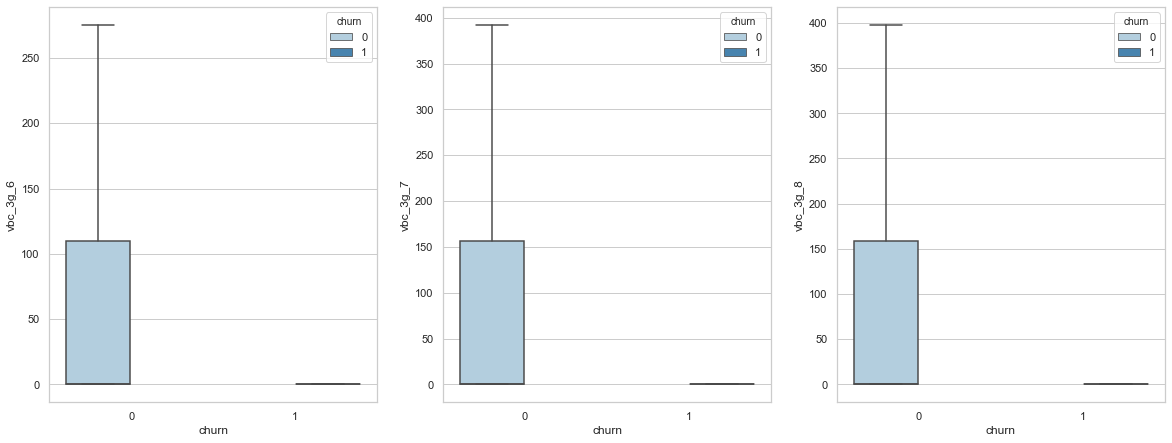

In [59]:
# Ploting for volume based cost :
plot_box_chart('vbc_3g')

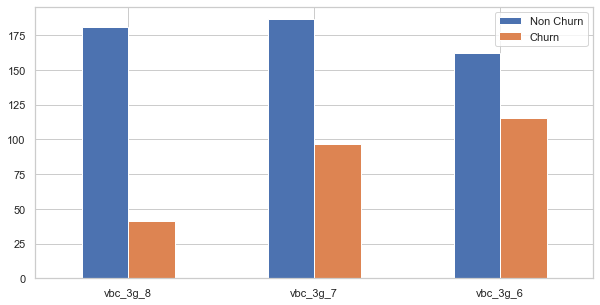

,vbc_3g_8,vbc_3g_7,vbc_3g_6
Non Churn,180.62,186.37,162.56
Churn,40.94,96.34,115.46


In [60]:
plot_mean_bar_chart(telecom_df_high_val_cust, vbc_column)


> <span style='color:blue'>**Analysis:** 
-    Significantly it showing that volume based cost for 3G is much lower for Churned customers as compared to Non-Churned Customers and also there is a drop in vbc in 8th month

In [61]:
# Checking Service schemes with validity smaller than a month for 2G/3G
SC_2g_or_3g_col = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('sachet_2g|sachet_3g',regex=True)]


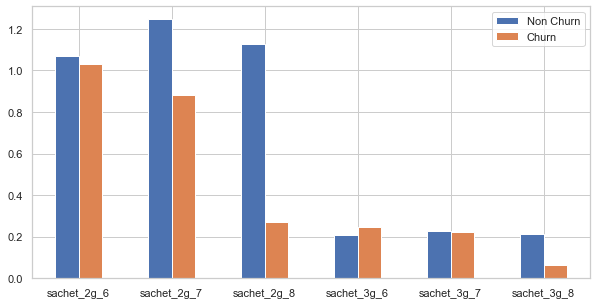

,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8
Non Churn,1.07,1.25,1.13,0.21,0.23,0.21
Churn,1.03,0.88,0.27,0.24,0.22,0.07


In [62]:
plot_mean_bar_chart(telecom_df_high_val_cust, SC_2g_or_3g_col)

> <span style='color:blue'>**Analysis:** We can see the drop in sachet services in 8th month for churned cutsomers

### d. Average Revenue Per User

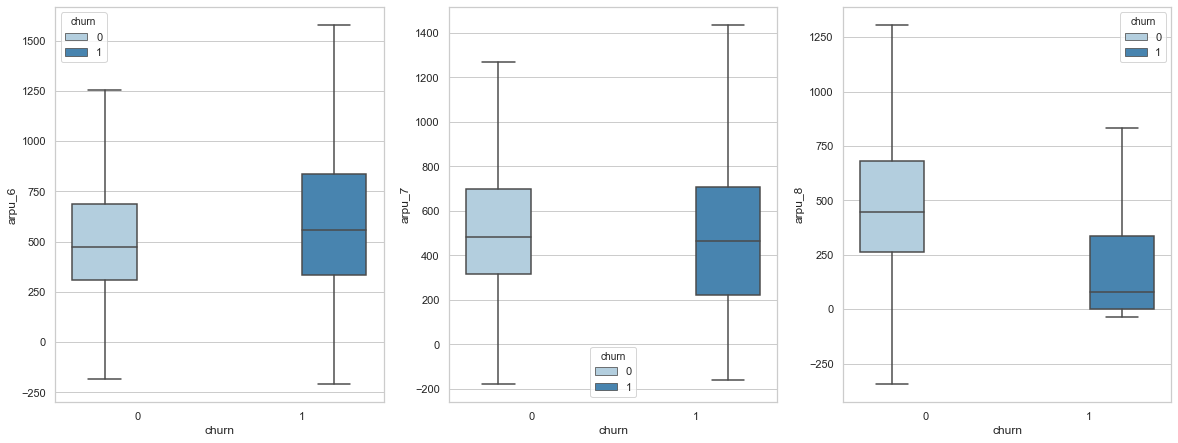

In [63]:
# Checking columns for average revenue per user
arpu_cols = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('arpu_')]

# Plotting arpu
plot_box_chart('arpu')

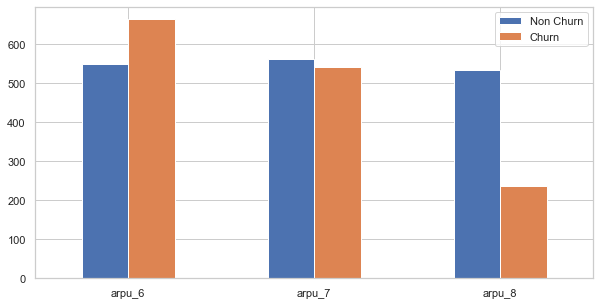

,arpu_6,arpu_7,arpu_8
Non Churn,549.55,562.93,532.87
Churn,663.71,541.15,237.66


In [64]:
plot_mean_bar_chart(telecom_df_high_val_cust, arpu_cols)

> <span style='color:blue'>**Analysis:** We can see that huge drops for Arpu in 8th month for churned customers

### e. Minutes of usage - voice calls

In [65]:
mou_cols = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('mou')]

In [66]:
mou_cols

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
       'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7',
       'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'total_og_mou_6',
       'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_6',
       'loc_ic_t2t_mo

In [67]:
meta_df = get_meta_data(telecom_df_high_val_cust[mou_cols])
meta_df.sort_values(["Null_Percentage"], axis=0,ascending=False, inplace=True)
col_to_display = ['Null_Percentage']
meta_df[col_to_display]

,Null_Percentage
isd_ic_mou_8,3.91
loc_ic_t2t_mou_8,3.91
loc_ic_t2m_mou_8,3.91
std_og_t2t_mou_8,3.91
loc_og_t2c_mou_8,3.91
loc_ic_t2f_mou_8,3.91
loc_og_t2f_mou_8,3.91
loc_ic_mou_8,3.91
std_og_mou_8,3.91
loc_og_t2m_mou_8,3.91


> <span style='color:blue'>**Analysis:** So for all minutes of usage columns the maximum missing % is 3.91 , means in these case the customer has not been used at all for that particular call type, thus we can fill the missing values with zero

In [68]:
# replaceing null values by 0 for minutes of usage variables
telecom_df_high_val_cust.loc[:,mou_cols] = telecom_df_high_val_cust.loc[:,mou_cols].replace(np.NaN,0)

In [69]:
mou_og_cols6 = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('.*_og_.*mou_6',regex=True)]

In [70]:
telecom_df_high_val_cust.loc[:,mou_og_cols6].describe()

,roam_og_mou_6,loc_og_t2t_mou_6,loc_og_t2m_mou_6,loc_og_t2f_mou_6,loc_og_t2c_mou_6,loc_og_mou_6,std_og_t2t_mou_6,std_og_t2m_mou_6,std_og_t2f_mou_6,std_og_mou_6,isd_og_mou_6,spl_og_mou_6,total_og_mou_6
count,"29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00"
mean,26.60,84.57,163.31,6.35,1.58,254.24,165.90,179.44,1.81,347.15,2.17,5.83,610.06
std,116.27,228.96,250.22,22.14,6.31,378.55,403.99,409.14,11.99,608.85,45.89,17.58,691.18
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,4.38,19.21,0.00,0.00,32.26,0.00,0.00,0.00,0.40,0.00,0.00,116.64
50%,0.00,24.36,77.26,0.00,0.00,124.59,2.71,16.36,0.00,45.08,0.00,0.23,410.63
75%,0.00,78.06,209.03,4.23,0.00,332.31,109.56,154.54,0.00,465.29,0.00,5.21,859.03
max,"3,775.11","6,431.33","4,729.74","1,466.03",271.44,"10,643.38","7,366.58","8,314.76",628.56,"8,432.99","5,900.66","1,023.21","10,674.03"


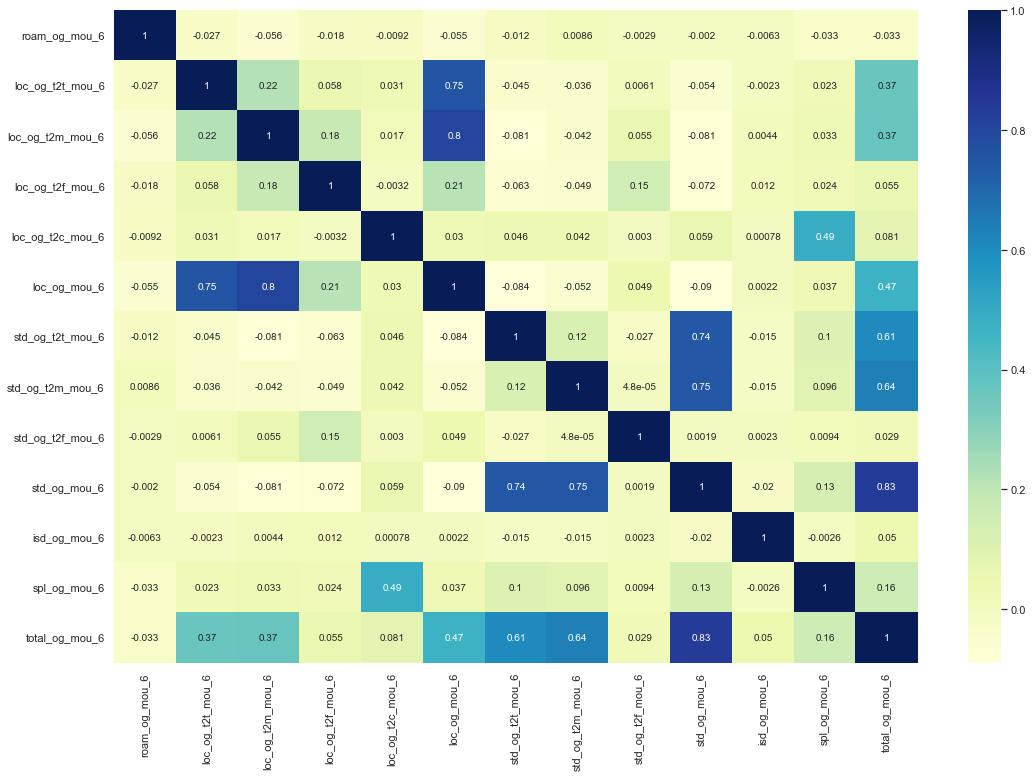

In [71]:
heatmap(18,12,telecom_df_high_val_cust.filter(mou_og_cols6))

> <span style='color:blue'>**Analysis:** 
-    We can see that total_og_mou_6, std_og_mou_6 and loc_og_mou_6 seems to have strong correlation with other fileds and they needs to be inspected to avoid any multicolinearity issues.

In [72]:
print(telecom_df_high_val_cust.loc[8,'total_og_mou_6'],"==",telecom_df_high_val_cust.loc[8,['loc_og_mou_6','std_og_mou_6','spl_og_mou_6','isd_og_mou_6','og_others_6']].sum())
print(telecom_df_high_val_cust.loc[8,'std_og_mou_6'],"==",telecom_df_high_val_cust.loc[8,['std_og_t2m_mou_6','std_og_t2t_mou_6','std_og_t2f_mou_6','std_og_loc_mou_6']].sum())
print(telecom_df_high_val_cust.loc[8,'loc_og_mou_6'],"==",telecom_df_high_val_cust.loc[8,['loc_og_t2m_mou_6','loc_og_t2t_mou_6','loc_og_t2f_mou_6','loc_og_2tc_mou_6']].sum())

508.36 == 508.34999999999997
130.26 == 130.25
378.09 == 378.09


> <span style='color:blue'>**Analysis:** 
-    We can see that total_og_mou_6, std_og_mou_6 and loc_og_mou_6 is a combination of other variables present in dataset.So we can remove these columns for all months from the data set

In [73]:
list_total_og_cols = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('total_og_mou|std_og_mou|loc_og_mou',regex=True)]
telecom_df_high_val_cust.drop(list_total_og_cols,axis=1,inplace=True)
log("Columns dropped - ")
list_total_og_cols.tolist()

> <span style='color:black'>Columns dropped - </span>

['loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8']

> **Checking for incoming mou variables**

In [74]:
mou_ic_cols6 = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('.*_ic_.*mou_6',regex=True)]

In [75]:
telecom_df_high_val_cust.loc[:,mou_ic_cols6].describe()

,roam_ic_mou_6,loc_ic_t2t_mou_6,loc_ic_t2m_mou_6,loc_ic_t2f_mou_6,loc_ic_mou_6,std_ic_t2t_mou_6,std_ic_t2m_mou_6,std_ic_t2f_mou_6,std_ic_mou_6,total_ic_mou_6,spl_ic_mou_6,isd_ic_mou_6
count,"29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00"
mean,16.12,65.51,150.47,15.29,231.28,14.90,29.21,2.70,46.81,290.12,0.06,10.80
std,76.34,163.86,219.32,45.79,315.01,77.75,98.28,19.11,137.60,365.74,0.19,76.79
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,6.10,28.09,0.00,47.91,0.00,0.00,0.00,1.03,72.89,0.00,0.00
50%,0.00,25.08,84.11,1.84,134.56,0.38,5.00,0.00,11.41,183.78,0.00,0.00
75%,0.00,67.48,188.74,11.98,297.26,8.19,23.63,0.11,41.49,372.16,0.00,0.00
max,"2,613.31","6,351.44","4,693.86","1,678.41","7,454.63","5,459.56","4,630.23","1,351.11","5,459.63","7,716.14",19.76,"6,789.41"


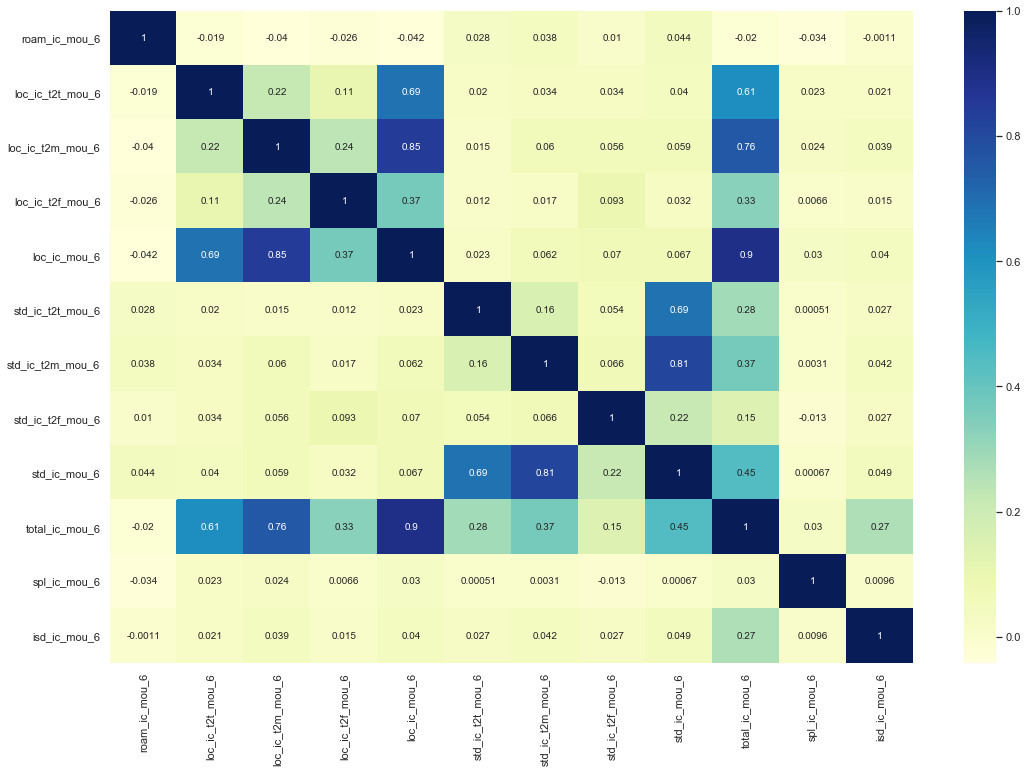

In [76]:
heatmap(18,12,telecom_df_high_val_cust.filter(mou_ic_cols6))

> <span style='color:blue'>**Analysis:** We can see that total_ic_mou_6, std_ic_mou_6 and loc_ic_mou_6 seems to have strong correlation with other fileds and they needs to be inspected to avoid any multicolinearity issues.

In [77]:
print(telecom_df_high_val_cust.loc[21,'total_ic_mou_6'],"==",telecom_df_high_val_cust.loc[21,['loc_ic_mou_6','roam_ic_mou_6','isd_ic_mou_6','spl_ic_mou_6','std_ic_mou_6']].sum())
print(telecom_df_high_val_cust.loc[21,'loc_ic_mou_6'],"==",telecom_df_high_val_cust.loc[21,['loc_ic_t2t_mou_6','loc_ic_t2m_mou_6','loc_ic_t2f_mou_6','loc_ic_t2c_mou_6']].sum())
print(telecom_df_high_val_cust.loc[21,'std_ic_mou_6'],"==",telecom_df_high_val_cust.loc[21,['std_ic_t2t_mou_6','std_ic_t2m_mou_6','std_ic_t2f_mou_6','std_ic_t2c_mou_6']].sum())

207.09 == 207.09
125.33 == 125.32000000000001
81.76 == 81.75


> <span style='color:blue'>**Analysis:** 
-    We can see that total_ic_mou_6, std_ic_mou_6 and loc_ic_mou_6 is a combination of other variables present in dataset.So we can remove these columns for all months from the data set

In [78]:
list_total_ic_cols = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('total_ic_mou|std_ic_mou|loc_ic_mou',regex=True)]
telecom_df_high_val_cust.drop(list_total_ic_cols,axis=1,inplace=True)
log("Columns dropped - ")
list_total_ic_cols.tolist()

> <span style='color:black'>Columns dropped - </span>

['loc_ic_mou_6',
 'loc_ic_mou_7',
 'loc_ic_mou_8',
 'std_ic_mou_6',
 'std_ic_mou_7',
 'std_ic_mou_8',
 'total_ic_mou_6',
 'total_ic_mou_7',
 'total_ic_mou_8']

### f. Offnet Usage

In [79]:
offnet_usage_service_col = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('offnet.*mou',regex=True)]

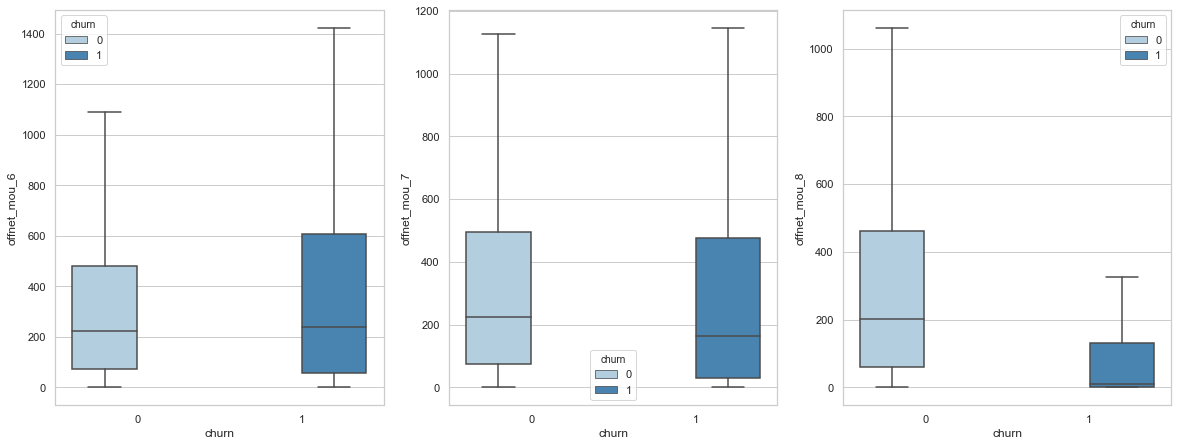

In [80]:
# Offnet mou values for churned and non churned customers
plot_box_chart('offnet_mou')

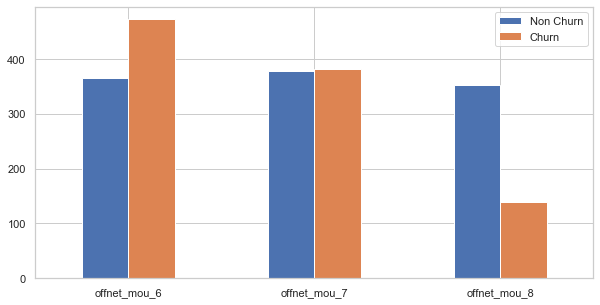

,offnet_mou_6,offnet_mou_7,offnet_mou_8
Non Churn,365.12,377.88,352.50
Churn,471.95,382.28,138.52


In [81]:
plot_mean_bar_chart(telecom_df_high_val_cust, offnet_usage_service_col)

> <span style='color:blue'>**Analysis:** We can see the drop for offnet mou services in the 8th month

### g. ONNET : All kind of calls within the same operator network

In [82]:
#minutes of usage related columns
onnet_usage_service =  telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('^onnet.*mou',regex=True)]

In [83]:
onnet_usage_service

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8'], dtype='object')

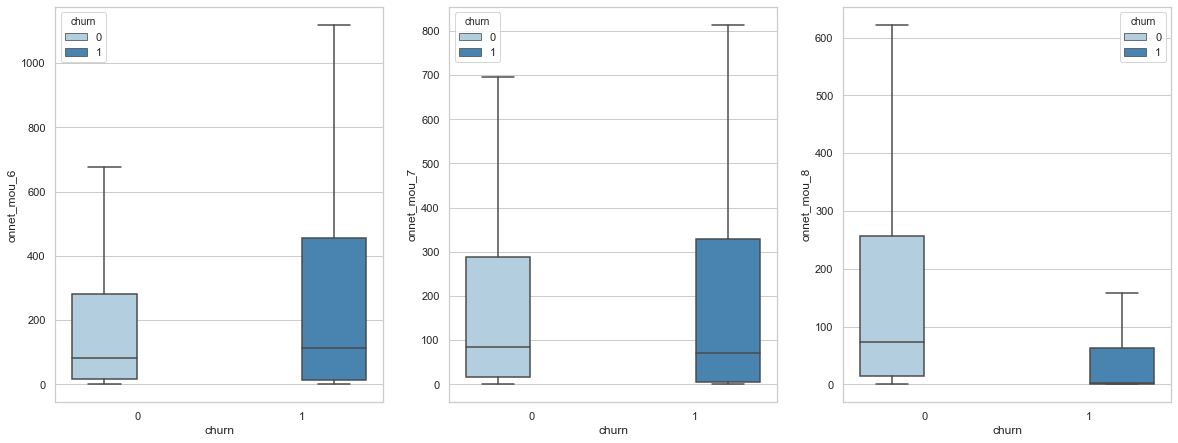

In [84]:
# Plotting offnet
plot_box_chart('onnet_mou')

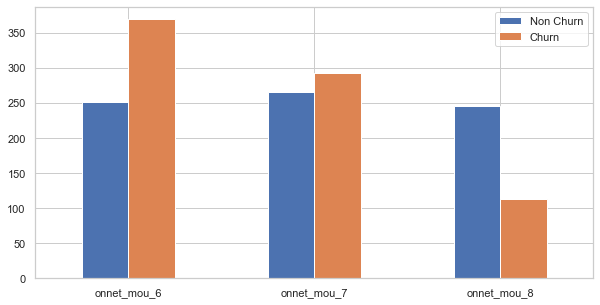

,onnet_mou_6,onnet_mou_7,onnet_mou_8
Non Churn,251.37,265.86,245.03
Churn,368.66,292.85,113.48


In [85]:
plot_mean_bar_chart(telecom_df_high_val_cust, onnet_usage_service)

> <span style='color:blue'>**Analysis:** We also see that there is a drop in Onnet usage in the 8th month for churned customers

### h. Tenure Analysis for Customers  

In [86]:
tenure_data = telecom_df_high_val_cust.copy()

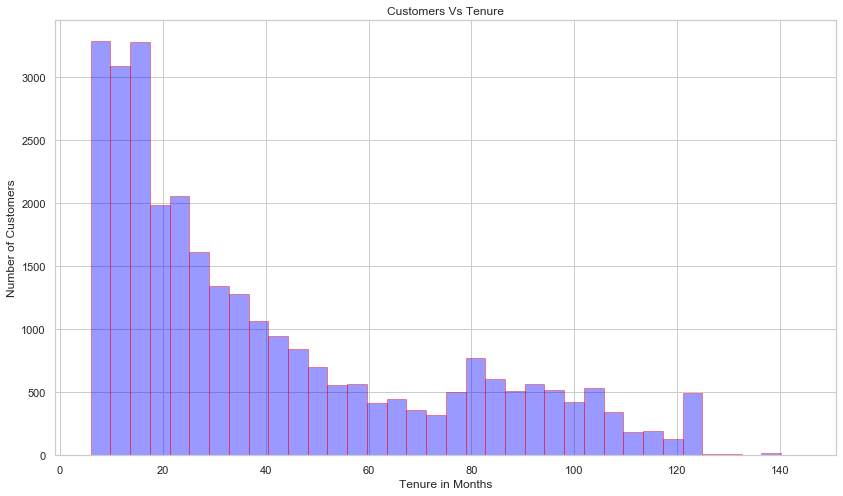

In [87]:
plt.figure(figsize=(14,8))
# aon --> Age on network - number of days the customer is using the operator T network
tenure_data['tenure'] = tenure_data['aon']/30
tenure_data['tenure'].head()
ax = sns.distplot(tenure_data['tenure'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue', 
             hist_kws={'edgecolor':'red'},
             kde_kws={'linewidth': 4})
ax.set_ylabel('Number of Customers')
ax.set_xlabel('Tenure in Months')
ax.set_title('Customers Vs Tenure')
plt.show()

In [88]:
tn_range = [0, 6, 12, 24, 60, 61]
tn_label = [ '0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
tenure_data['tenure_range'] = pd.cut(tenure_data['tenure'], tn_range, labels=tn_label)
tenure_data['tenure_range'].head()

0     2-5 Yrs    
7     2-5 Yrs    
8     6-12 Months
21    1-2 Yrs    
23    1-2 Yrs    
Name: tenure_range, dtype: category
Categories (5, object): [0-6 Months < 6-12 Months < 1-2 Yrs < 2-5 Yrs < 5 Yrs and above]

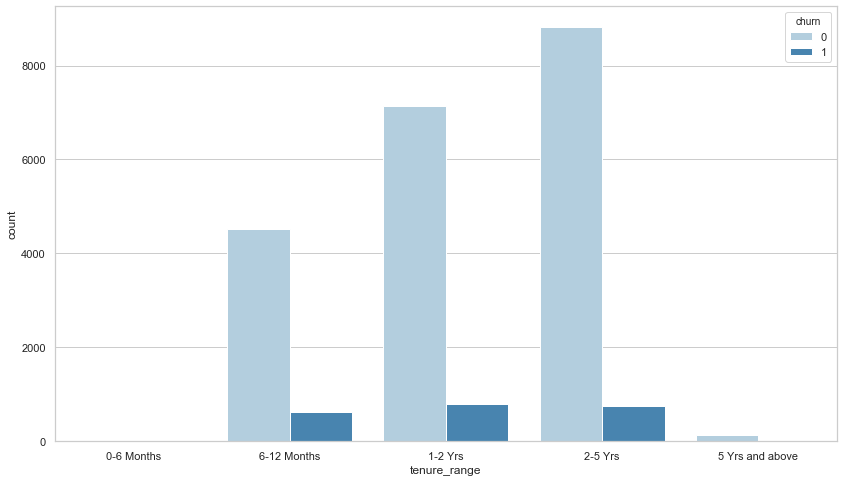

In [89]:
plt.figure(figsize=(14,8))
sns.countplot(x = 'tenure_range', hue = 'churn',data = tenure_data,palette=("Blues"))
plt.show()

### Checking columns with more than 30% NA values.

In [90]:
meta_df = get_meta_data(telecom_df_high_val_cust)
meta_df = meta_df[meta_df["Null_Percentage"] > 30]
meta_df.sort_values(["Null_Percentage"], axis=0,ascending=False, inplace=True)
col_to_display = ['Null_Percentage']
meta_df[col_to_display]

,Null_Percentage
date_of_last_rech_data_8,46.80
night_pck_user_8,46.80
fb_user_8,46.80
date_of_last_rech_data_6,44.11
night_pck_user_6,44.11
fb_user_6,44.11
date_of_last_rech_data_7,43.12
night_pck_user_7,43.12
fb_user_7,43.12


In [91]:
#Dropping 30% column
is_more_30 = meta_df.index
telecom_df_high_val_cust.drop(telecom_df_high_val_cust[is_more_30],axis=1,inplace=True)

In [92]:
telecom_df_high_val_cust.shape

(29953, 124)

### Replacing NAN values

In [93]:
meta_df = get_meta_data(telecom_df_high_val_cust)
meta_df = meta_df[meta_df["Null_Percentage"] > 0]
meta_df.sort_values(["Null_Percentage"], axis=0,ascending=False, inplace=True)
col_to_display = ['Null_Percentage']
meta_df[col_to_display]

,Null_Percentage
og_others_8,3.91
ic_others_8,3.91
date_of_last_rech_8,1.94
og_others_6,1.81
ic_others_6,1.81
og_others_7,1.79
ic_others_7,1.79
date_of_last_rech_7,0.33
date_of_last_rech_6,0.24


In [94]:
telecom_df_high_val_cust[meta_df.index].head(3)

,og_others_8,ic_others_8,date_of_last_rech_8,og_others_6,ic_others_6,og_others_7,ic_others_7,date_of_last_rech_7,date_of_last_rech_6
0,0.00,0.00,2014-08-08,nan,nan,nan,nan,2014-07-16,2014-06-21
7,0.00,15.14,2014-08-26,0.00,15.74,0.00,15.19,2014-07-25,2014-06-27
8,0.00,0.00,2014-08-30,0.00,0.00,0.00,0.00,2014-07-31,2014-06-25


> **Exploring/Imputing Numeric field**

In [95]:
numberic_col = ['og_others_8', 'ic_others_8', 'og_others_6','ic_others_6', 'og_others_7', 'ic_others_7']

- Replacing NaN values with zero for all numeric data as most of the data is clean and will not impact the analysis

In [96]:
for i in numberic_col:
    telecom_df_high_val_cust.loc[telecom_df_high_val_cust[i].isnull(),i]=0

In [97]:
telecom_df_high_val_cust[meta_df.index].head(3)

,og_others_8,ic_others_8,date_of_last_rech_8,og_others_6,ic_others_6,og_others_7,ic_others_7,date_of_last_rech_7,date_of_last_rech_6
0,0.00,0.00,2014-08-08,0.00,0.00,0.00,0.00,2014-07-16,2014-06-21
7,0.00,15.14,2014-08-26,0.00,15.74,0.00,15.19,2014-07-25,2014-06-27
8,0.00,0.00,2014-08-30,0.00,0.00,0.00,0.00,2014-07-31,2014-06-25


In [98]:
meta_df = get_meta_data(telecom_df_high_val_cust)
meta_df = meta_df[meta_df["Null_Percentage"] > 0]
meta_df.sort_values(["Null_Percentage"], axis=0,ascending=False, inplace=True)
col_to_display = ['Null_Percentage']
meta_df[col_to_display]

,Null_Percentage
date_of_last_rech_8,1.94
date_of_last_rech_7,0.33
date_of_last_rech_6,0.24


### 3. Derive new features.

In [99]:
telecom_df_final = telecom_df_high_val_cust.copy()
print(telecom_df_final.shape)
telecom_df_final.head(3)

(29953, 124)


,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,total_avg_rech_amnt_6_7_GPhase,churn
0,7000842753,197.38,214.82,213.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.16,0.00,0.00,4.13,0.00,0.00,1.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4,3,2,362,252,252,252,252,252,2014-06-21,2014-07-16,2014-08-08,252,252,252,1.00,1.00,1.00,252.00,252.00,252.00,252.00,252.00,252.00,30.13,1.32,5.75,83.57,150.76,109.61,0,0,0,0,0,0,1,1,1,0,0,0,968,30.40,0.00,101.20,252.00,252.00,252.00,559.00,1
7,7000701601,"1,069.18","1,349.85","3,171.48",57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.00,0.00,0.00,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,0.00,0.18,10.01,4.50,0.00,6.50,0.00,0.00,0.00,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,0.21,0.00,0.00,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,3638,1580,790,1580,2014-06-27,2014-07-25,2014-08-26,0,0,779,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,802,57.74,19.38,18.74,0.00,0.00,0.00,"1,185.00",1
8,7001524846,378.72,492.22,137.36,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.00,0.00,7.15,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10.23,0.00,0.00,0.00,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,19,21,14,437,601,120,90,154,30,2014-06-25,2014-07-31,2014-08-30,50,0,10,0.00,2.00,3.00,0.00,154.00,23.00,0.00,177.00,69.00,0.00,356.00,0.03,0.00,750.95,11.94,0,1,0,0,1,3,0,0,0,0,0,0,315,21.03,910.65,122.16,0.00,354.00,207.00,696.00,0


In [100]:
telecom_df_final.drop(["total_avg_rech_amnt_6_7_GPhase"],axis=1,inplace=True)
telecom_df_final.drop(telecom_df_high_val_cust.filter(regex='date_').columns,axis=1,inplace=True)
print (telecom_df_final.shape)

col_list = telecom_df_final.filter(regex='_6|_7').columns.str[:-2]
for idx, col in enumerate(col_list.unique()):
    print(col)
    avg_col_name = "avg_"+col+"_av67"
    col_6 = col+"_6"
    col_7 = col+"_7"
    telecom_df_final[avg_col_name] = (telecom_df_final[col_6]  + telecom_df_final[col_7])/ 2


(29953, 120)
arpu
onnet_mou
offnet_mou
roam_ic_mou
roam_og_mou
loc_og_t2t_mou
loc_og_t2m_mou
loc_og_t2f_mou
loc_og_t2c_mou
std_og_t2t_mou
std_og_t2m_mou
std_og_t2f_mou
isd_og_mou
spl_og_mou
og_others
loc_ic_t2t_mou
loc_ic_t2m_mou
loc_ic_t2f_mou
std_ic_t2t_mou
std_ic_t2m_mou
std_ic_t2f_mou
spl_ic_mou
isd_ic_mou
ic_others
total_rech_num
total_rech_amt
max_rech_amt
last_day_rch_amt
total_rech_data
max_rech_data
av_rech_amt_data
vol_2g_mb
vol_3g_mb
monthly_2g
sachet_2g
monthly_3g
sachet_3g
vbc_3g
total_rech_amt_data


In [101]:
col_list_to_drop = telecom_df_final.filter(regex='_6|_7')
telecom_df_final.drop(col_list_to_drop,axis=1,inplace=True)
print (telecom_df_final.shape)

(29953, 81)


In [102]:
telecom_df_final.head(3)

,mobile_number,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aon,vbc_3g_8,total_rech_amt_data_8,churn,avg_arpu_av67,avg_onnet_mou_av67,avg_offnet_mou_av67,avg_roam_ic_mou_av67,avg_roam_og_mou_av67,avg_loc_og_t2t_mou_av67,avg_loc_og_t2m_mou_av67,avg_loc_og_t2f_mou_av67,avg_loc_og_t2c_mou_av67,avg_std_og_t2t_mou_av67,avg_std_og_t2m_mou_av67,avg_std_og_t2f_mou_av67,avg_isd_og_mou_av67,avg_spl_og_mou_av67,avg_og_others_av67,avg_loc_ic_t2t_mou_av67,avg_loc_ic_t2m_mou_av67,avg_loc_ic_t2f_mou_av67,avg_std_ic_t2t_mou_av67,avg_std_ic_t2m_mou_av67,avg_std_ic_t2f_mou_av67,avg_spl_ic_mou_av67,avg_isd_ic_mou_av67,avg_ic_others_av67,avg_total_rech_num_av67,avg_total_rech_amt_av67,avg_max_rech_amt_av67,avg_last_day_rch_amt_av67,avg_total_rech_data_av67,avg_max_rech_data_av67,avg_av_rech_amt_data_av67,avg_vol_2g_mb_av67,avg_vol_3g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,avg_vbc_3g_av67,avg_total_rech_amt_data_av67
0,7000842753,213.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.16,4.13,1.15,0.00,0.00,0.00,0.00,0.00,0.00,2,252,252,252,1.00,252.00,252.00,5.75,109.61,0,0,1,0,968,30.40,252.00,1,206.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.50,307.00,252.00,252.00,1.00,252.00,252.00,15.72,117.16,0.00,0.00,1.00,0.00,50.60,252.00
7,7000701601,"3,171.48",52.29,325.91,31.64,38.06,40.28,162.28,53.23,0.00,12.01,49.14,16.68,10.01,6.50,0.00,27.31,121.19,39.53,30.39,141.33,22.21,0.00,31.59,15.14,7,3638,1580,779,0.00,0.00,0.00,0.00,0.00,0,0,0,0,802,57.74,0.00,1,"1,209.51",56.26,510.29,24.86,18.16,41.38,378.00,58.64,0.00,13.79,40.83,13.37,0.09,2.25,0.00,45.20,219.53,126.81,24.36,109.22,43.22,0.10,8.29,15.46,5.00,"1,185.00","1,185.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,19.06,0.00
8,7001524846,137.36,35.08,136.48,0.00,0.00,12.49,50.54,0.00,7.15,22.58,75.69,0.00,0.00,10.23,0.00,0.31,15.48,0.00,0.10,0.65,0.00,0.00,0.00,0.00,14,120,30,10,3.00,23.00,69.00,0.03,11.94,0,3,0,0,315,21.03,207.00,0,435.47,382.36,87.64,0.00,0.00,257.36,75.77,0.00,0.00,125.00,11.86,0.00,0.00,0.00,0.00,16.84,35.78,0.00,0.29,13.25,0.00,0.00,0.00,0.00,20.00,519.00,122.00,25.00,1.00,77.00,88.50,178.00,375.48,0.50,0.50,0.00,0.00,516.40,177.00


> <span style='color:blue'>**Analysis:** 
-    We have merged most of the columns related to month 6 & 7 so to reduce the number of features. By doing this apporach we have reduced the fetures from 124 to 81.  

## <a id='5'>5. Modelling</a>


### PCA : Principal Component Analysis

In [103]:
telecom_pca_df = telecom_df_final.copy()

In [104]:
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA

def split_date(df):
    Y = df["churn"]
    X = df.drop(["churn","mobile_number"],axis=1)
    return X,Y
    
def scale_data(X):
    scaler = StandardScaler()
    X_col = X.columns
    X_scaled = scaler.fit_transform(X)
    X_scale_final = pd.DataFrame(X_scaled, columns=X_col)
    log("Scaling the data ....")
    return X_scale_final

def get_scree_plot(X):
    pca = PCA(svd_solver='randomized', random_state=101)
    pca.fit(X)
    fig = plt.figure(figsize = (8,6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()
    return pca
    
    
def resampling_data(X,Y,feature_number,train_size=0.7,test_size=0.3) :
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, train_size=train_size, random_state=1)

    log("Shape of train datatset before : "+str(x_train.shape))
    log("Percenatge of Churned customer data : "+str(round(100*Y.sum()/len(Y),2)))
    log("Applying SMOTE to normalize imbalance ....")

    #Initializing SMOTE: Synthetic Minority Over-sampling Technique
    # using this as data is skewed 
    smote = SMOTE(kind = "regular")
    x_tr,y_tr = smote.fit_sample(x_train,y_train)
    log("Shape of train datatset after SMOTE : "+str(x_tr.shape))

    # Applying PCA : Pricnipal Component Analysis
    pca = IncrementalPCA(n_components=feature_number)    
    x_tr_pca = pca.fit_transform(x_tr)
    x_test_pca = pca.transform(x_test)
    log("Shape of train datatset after PCA : "+str(x_tr_pca.shape))

    return x_tr_pca,x_test_pca,y_tr,y_test

In [105]:
X,Y=split_date(telecom_pca_df)

In [106]:
X.head(2)

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aon,vbc_3g_8,total_rech_amt_data_8,avg_arpu_av67,avg_onnet_mou_av67,avg_offnet_mou_av67,avg_roam_ic_mou_av67,avg_roam_og_mou_av67,avg_loc_og_t2t_mou_av67,avg_loc_og_t2m_mou_av67,avg_loc_og_t2f_mou_av67,avg_loc_og_t2c_mou_av67,avg_std_og_t2t_mou_av67,avg_std_og_t2m_mou_av67,avg_std_og_t2f_mou_av67,avg_isd_og_mou_av67,avg_spl_og_mou_av67,avg_og_others_av67,avg_loc_ic_t2t_mou_av67,avg_loc_ic_t2m_mou_av67,avg_loc_ic_t2f_mou_av67,avg_std_ic_t2t_mou_av67,avg_std_ic_t2m_mou_av67,avg_std_ic_t2f_mou_av67,avg_spl_ic_mou_av67,avg_isd_ic_mou_av67,avg_ic_others_av67,avg_total_rech_num_av67,avg_total_rech_amt_av67,avg_max_rech_amt_av67,avg_last_day_rch_amt_av67,avg_total_rech_data_av67,avg_max_rech_data_av67,avg_av_rech_amt_data_av67,avg_vol_2g_mb_av67,avg_vol_3g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,avg_vbc_3g_av67,avg_total_rech_amt_data_av67
0,213.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.16,4.13,1.15,0.00,0.00,0.00,0.00,0.00,0.00,2,252,252,252,1.00,252.00,252.00,5.75,109.61,0,0,1,0,968,30.40,252.00,206.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.50,307.00,252.00,252.00,1.00,252.00,252.00,15.72,117.16,0.00,0.00,1.00,0.00,50.60,252.00
7,"3,171.48",52.29,325.91,31.64,38.06,40.28,162.28,53.23,0.00,12.01,49.14,16.68,10.01,6.50,0.00,27.31,121.19,39.53,30.39,141.33,22.21,0.00,31.59,15.14,7,3638,1580,779,0.00,0.00,0.00,0.00,0.00,0,0,0,0,802,57.74,0.00,"1,209.51",56.26,510.29,24.86,18.16,41.38,378.00,58.64,0.00,13.79,40.83,13.37,0.09,2.25,0.00,45.20,219.53,126.81,24.36,109.22,43.22,0.10,8.29,15.46,5.00,"1,185.00","1,185.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,19.06,0.00


In [107]:
Y.head(2)

0    1
7    1
Name: churn, dtype: int64

> **Percentage distribution of churn/non-churn cutomer data**

In [108]:
log("Percenatge of Churned Customer data : "+str(round(100*Y.sum()/len(Y),2)))

> <span style='color:black'>Percenatge of Churned Customer data : 8.12</span>

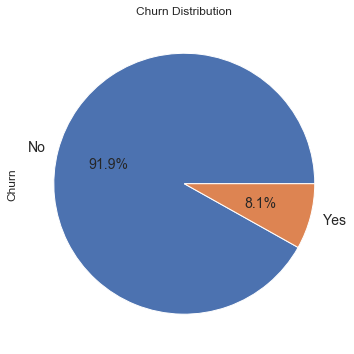

In [109]:
#Churn Distribution
pie_chart = telecom_pca_df['churn'].value_counts()*100.0 /len(telecom_pca_df)
ax = pie_chart.plot.pie(autopct='%.1f%%', labels = ['No', 'Yes'],figsize =(8,6), fontsize = 14 )                                                                           
ax.set_ylabel('Churn',fontsize = 12)
ax.set_title('Churn Distribution', fontsize = 12)
plt.show()

> **Scaling the data so as to normalize all the fields**

In [110]:
X_scaled = scale_data(X)
print(X_scaled.shape)
X_scaled.head(5)

> <span style='color:black'>Scaling the data ....</span>

(29953, 79)


,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aon,vbc_3g_8,total_rech_amt_data_8,avg_arpu_av67,avg_onnet_mou_av67,avg_offnet_mou_av67,avg_roam_ic_mou_av67,avg_roam_og_mou_av67,avg_loc_og_t2t_mou_av67,avg_loc_og_t2m_mou_av67,avg_loc_og_t2f_mou_av67,avg_loc_og_t2c_mou_av67,avg_std_og_t2t_mou_av67,avg_std_og_t2m_mou_av67,avg_std_og_t2f_mou_av67,avg_isd_og_mou_av67,avg_spl_og_mou_av67,avg_og_others_av67,avg_loc_ic_t2t_mou_av67,avg_loc_ic_t2m_mou_av67,avg_loc_ic_t2f_mou_av67,avg_std_ic_t2t_mou_av67,avg_std_ic_t2m_mou_av67,avg_std_ic_t2f_mou_av67,avg_spl_ic_mou_av67,avg_isd_ic_mou_av67,avg_ic_others_av67,avg_total_rech_num_av67,avg_total_rech_amt_av67,avg_max_rech_amt_av67,avg_last_day_rch_amt_av67,avg_total_rech_data_av67,avg_max_rech_data_av67,avg_av_rech_amt_data_av67,avg_vol_2g_mb_av67,avg_vol_3g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,avg_vbc_3g_av67,avg_total_rech_amt_data_av67
0,-0.59,-0.51,-0.70,-0.17,-0.19,-0.34,-0.65,-0.30,-0.24,-0.37,-0.38,-0.15,-0.04,-0.32,-0.02,-0.39,-0.66,-0.31,-0.19,-0.27,-0.13,-0.24,-0.16,-0.10,-0.86,-0.54,0.53,1.10,-0.21,1.62,0.66,-0.32,-0.26,-0.38,-0.42,1.28,-0.18,-0.25,-0.33,-0.13,-0.82,-0.60,-0.82,-0.22,-0.25,-0.38,-0.70,-0.30,-0.27,-0.44,-0.47,-0.16,-0.05,-0.37,-0.14,-0.42,-0.73,-0.35,-0.20,-0.32,-0.15,-0.27,-0.15,-0.10,-0.96,-0.69,0.53,1.30,-0.28,1.68,0.64,-0.37,-0.29,-0.46,-0.47,1.36,-0.23,-0.30,-0.19
1,5.30,-0.40,-0.02,0.26,0.17,-0.17,0.04,2.43,-0.24,-0.34,-0.26,1.38,0.18,-0.00,-0.02,-0.22,-0.12,0.58,0.23,1.10,0.99,-0.24,0.29,1.09,-0.32,4.99,8.19,4.73,-0.54,-0.66,-0.62,-0.34,-0.38,-0.38,-0.42,-0.34,-0.18,-0.43,-0.26,-0.29,1.51,-0.47,0.29,0.16,-0.06,-0.20,0.92,2.49,-0.27,-0.41,-0.36,1.00,-0.05,-0.24,-0.14,-0.13,0.33,2.50,0.12,0.84,2.26,0.43,-0.04,1.03,-0.79,1.02,6.57,-0.87,-0.65,-0.77,-0.74,-0.42,-0.43,-0.46,-0.47,-0.39,-0.23,-0.38,-0.40
2,-0.74,-0.43,-0.41,-0.17,-0.19,-0.29,-0.43,-0.30,0.76,-0.32,-0.20,-0.15,-0.04,0.18,-0.02,-0.39,-0.61,-0.33,-0.19,-0.26,-0.13,-0.24,-0.16,-0.10,0.43,-0.76,-0.75,-0.57,0.46,-0.45,-0.27,-0.34,-0.37,-0.38,0.77,-0.34,-0.18,-0.93,-0.35,-0.16,-0.29,0.27,-0.63,-0.22,-0.25,0.77,-0.38,-0.30,-0.27,-0.12,-0.44,-0.16,-0.05,-0.37,-0.14,-0.31,-0.56,-0.35,-0.20,-0.18,-0.15,-0.27,-0.15,-0.10,0.95,-0.28,-0.32,-0.65,-0.28,-0.02,-0.26,0.17,0.02,0.83,-0.27,-0.39,-0.23,0.88,-0.25
3,0.26,-0.33,1.35,-0.17,-0.19,-0.24,-0.20,-0.22,-0.24,-0.22,1.76,-0.15,-0.04,-0.32,-0.02,-0.27,-0.08,-0.09,-0.19,0.71,-0.13,-0.24,-0.16,-0.10,1.84,0.22,-0.64,-0.29,-0.54,-0.66,-0.62,-0.34,-0.38,-0.38,-0.42,-0.34,-0.18,-0.51,-0.40,-0.29,-0.01,-0.33,0.99,-0.22,-0.25,-0.36,-0.32,-0.29,-0.27,-0.15,1.40,-0.16,-0.05,-0.37,-0.14,-0.38,-0.26,-0.27,-0.07,0.24,-0.15,-0.27,-0.15,-0.10,1.41,-0.04,-0.78,-0.65,-0.65,-0.77,-0.74,-0.42,-0.43,-0.46,-0.47,-0.39,-0.23,-0.43,-0.40
4,-0.28,-0.44,-0.27,-0.17,-0.19,-0.20,-0.01,-0.30,2.24,-0.37,-0.29,-0.15,-0.04,0.55,-0.02,0.09,0.00,-0.32,-0.01,0.15,-0.13,-0.24,-0.10,0.93,-0.64,-0.24,0.11,-0.64,0.13,0.96,0.76,-0.34,0.72,-0.38,-0.42,1.28,0.72,-0.63,-0.31,0.05,-0.99,-0.49,-0.63,-0.22,-0.25,-0.16,-0.35,-0.30,-0.27,-0.44,-0.46,-0.16,-0.05,-0.37,-0.14,-0.16,-0.22,-0.35,-0.20,-0.23,-0.15,-0.27,0.04,0.10,-0.90,-0.84,-0.53,-0.10,-0.28,0.10,0.23,-0.42,-0.07,-0.46,-0.47,1.36,-0.23,-0.36,-0.11


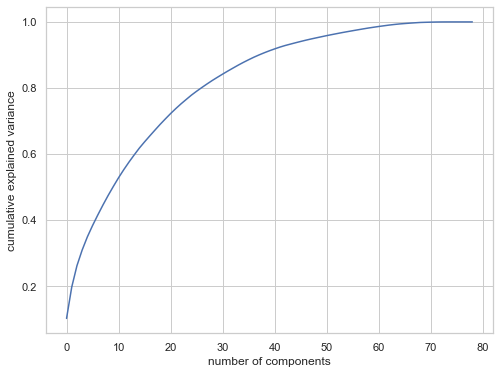

,PC1,PC2,PC3,Feature
0,0.00,0.29,0.15,arpu_8
1,-0.11,0.11,0.15,onnet_mou_8
2,-0.10,0.20,0.11,offnet_mou_8
3,-0.01,0.05,0.01,roam_ic_mou_8
4,-0.02,0.07,0.03,roam_og_mou_8
5,-0.03,0.10,0.02,loc_og_t2t_mou_8
6,-0.03,0.18,-0.03,loc_og_t2m_mou_8
7,0.01,0.11,-0.09,loc_og_t2f_mou_8
8,-0.01,0.02,0.08,loc_og_t2c_mou_8
9,-0.11,0.07,0.16,std_og_t2t_mou_8


In [111]:
pca = get_scree_plot(X_scaled) # scree plot

col = list(X_scaled.columns)
df_pca = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'PC3':pca.components_[2],'Feature':col})
df_pca.head(10)

In [112]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 10.34,  19.83,  26.28,  31.01,  34.99,  38.42,  41.6 ,  44.64,
        47.53,  50.26,  52.88,  55.32,  57.61,  59.77,  61.85,  63.73,
        65.53,  67.3 ,  69.04,  70.69,  72.3 ,  73.81,  75.24,  76.57,
        77.88,  79.06,  80.18,  81.26,  82.3 ,  83.28,  84.23,  85.16,
        86.06,  86.95,  87.79,  88.58,  89.34,  90.04,  90.69,  91.3 ,
        91.86,  92.4 ,  92.88,  93.3 ,  93.71,  94.11,  94.5 ,  94.86,
        95.2 ,  95.54,  95.87,  96.18,  96.49,  96.79,  97.07,  97.35,
        97.63,  97.9 ,  98.16,  98.4 ,  98.63,  98.84,  99.05,  99.23,
        99.39,  99.52,  99.64,  99.75,  99.85,  99.9 ,  99.94,  99.98,
       100.  , 100.01, 100.01, 100.01, 100.01, 100.01, 100.01])

> <span style='color:blue'>**Analysis:** Looks like 60 components are enough to describe 95% of the variance in the dataset.We'll choose **60** components for our modeling

In [113]:
x_train, x_test, y_train, y_test = resampling_data(X_scaled,Y,60)

> <span style='color:black'>Shape of train datatset before : (20967, 79)</span>

> <span style='color:black'>Percenatge of Churned customer data : 8.12</span>

> <span style='color:black'>Applying SMOTE to normalize imbalance ....</span>

> <span style='color:black'>Shape of train datatset after SMOTE : (38528, 79)</span>

> <span style='color:black'>Shape of train datatset after PCA : (38528, 60)</span>

In [114]:
x_train.shape

(38528, 60)

> <span style='color:blue'>**Analysis:** SMOTE bloated the dataset and balanced it by adding skewed data values.

In [115]:
def get_regression_data(df):
    X,Y=split_date(df)
    x_train, x_test, y_train, y_test = resampling_data(scale_data(X),Y,60)
    return x_train, x_test, y_train, y_test

from sklearn.preprocessing import scale
from sklearn import svm
from sklearn import metrics
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold,GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report
from sklearn.metrics import recall_score,precision_score,roc_auc_score,f1_score,accuracy_score,confusion_matrix

consolidate_summary = pd.DataFrame()

def plot_confusion_matrix(cm):
    """
    This function prints and plots the confusion matrix.
    """
    classes=[0,1]
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def get_svm_model_stats(x_train, x_test, y_train, y_test,kernel): 
    model = svm.SVC(kernel=kernel) # build model
    model.fit(x_train, y_train) # fit model
    predictions = model.predict(x_test) # print
    accuracy_score = round(metrics.accuracy_score(y_true=y_test, y_pred=predictions),2)
    log("Model selected - "+kernel.upper()+" and accuracy score for kernal is "+str(accuracy_score*100))
    model_name = "SVM (Default)-"+kernel
    print_model_metrics(y_test,predictions,model_name)
    
def display_hyper_stats(cv_results,param_value):
    gamma = cv_results[cv_results['param_gamma']==param_value]
    plt.plot(gamma["param_C"], gamma["mean_test_score"])
    plt.plot(gamma["param_C"], gamma["mean_train_score"])
    plt.xlabel('C')
    plt.ylabel('Accuracy')
    plt.title("Gamma="+str(param_value))
    plt.ylim([0.60, 1])
    plt.legend(['test accuracy', 'train accuracy'], loc='lower right')
    plt.xscale('log')  
    
def print_model_metrics(y_test,y_pred,model_name):
    header(model_name+" Model Stats Scores Summary : ")
    cp = confusion_matrix(y_test,y_pred)
    plt.figure()
    plot_confusion_matrix(cp)
    plt.show()
    
    accuracy = round(accuracy_score(y_test,y_pred),2)
    recall = round(recall_score(y_test,y_pred),2)
    precision = round(precision_score(y_test,y_pred),2)
    auc = round(roc_auc_score(y_test,y_pred),2)
    f1 = round(f1_score(y_test,y_pred),2)
    
    data = [[model_name,accuracy,recall,precision,auc,f1]] 
    df = pd.DataFrame(data, columns = ['Model', 'Accuracy','Precision','Recall','AUC','F1'])
    add_to_global_summary(df)
    return df 

def add_to_global_summary(df) :
    global consolidate_summary 
    consolidate_summary = consolidate_summary.append(df,ignore_index=True)

## <a id='5.1'>5.1. Logistic Regression Modelling</a>

In [116]:
#Training the model on the train data
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

lr = LogisticRegression()
model_LR = lr.fit(x_train,y_train)
#Making prediction on the test data
pred_probs_test = model_LR.predict_proba(x_test)[:,1]
log("Linear Regression Accurancy : "+"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test)))

> <span style='color:black'>Linear Regression Accurancy : 0.89</span>

## <a id='5.2'>5.2. SVM Regression Modelling</a> 

> Let's fist build two basic models - linear and non-linear with default hyperparameters, and compare the accuracies.

#### Preparing data

In [117]:
telecom_svm_df = telecom_df_final.copy()
x_train, x_test, y_train, y_test = get_regression_data(telecom_svm_df)

> <span style='color:black'>Scaling the data ....</span>

> <span style='color:black'>Shape of train datatset before : (20967, 79)</span>

> <span style='color:black'>Percenatge of Churned customer data : 8.12</span>

> <span style='color:black'>Applying SMOTE to normalize imbalance ....</span>

> <span style='color:black'>Shape of train datatset after SMOTE : (38528, 79)</span>

> <span style='color:black'>Shape of train datatset after PCA : (38528, 60)</span>

#### Applying Regression 

> <span style='color:black'>Model selected - LINEAR and accuracy score for kernal is 83.0</span>

------ 

### SVM (Default)-linear Model Stats Scores Summary : 

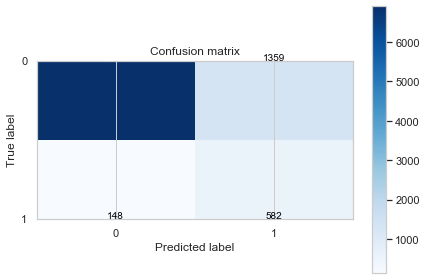

In [118]:
get_svm_model_stats(x_train, x_test, y_train, y_test,"linear")

> <span style='color:black'>Model selected - RBF and accuracy score for kernal is 87.0</span>

------ 

### SVM (Default)-rbf Model Stats Scores Summary : 

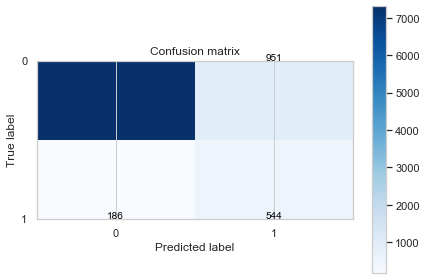

In [119]:
get_svm_model_stats(x_train,x_test, y_train, y_test,"rbf")

> <span style='color:blue'>**Analysis:** 
-    The non-linear model gives approx. 87% accuracy. Thus, going forward, let's choose hyperparameters corresponding to non-linear models.

> ### Grid Search: Hyperparameter Tuning
- Let's now tune the model to find the optimal values of C and gamma corresponding to an RBF kernel. We'll use 5-fold cross validation.

In [120]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 101)

# Set the parameters by cross-validation
hyper_params = [ {'gamma': [1e-1,1e-2, 1e-3, 1e-4], 'C': [1, 10, 100, 1000]}]

# specify model
model = svm.SVC(kernel="rbf")

# set up GridSearchCV()
model_cv_svm = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        n_jobs = -1,
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv_svm.fit(x_train, y_train)  


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 22.2min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 55.7min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=101, shuffle=True),
             error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000],
                          'gamma': [0.1, 0.01, 0.001, 0.0001]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=1)

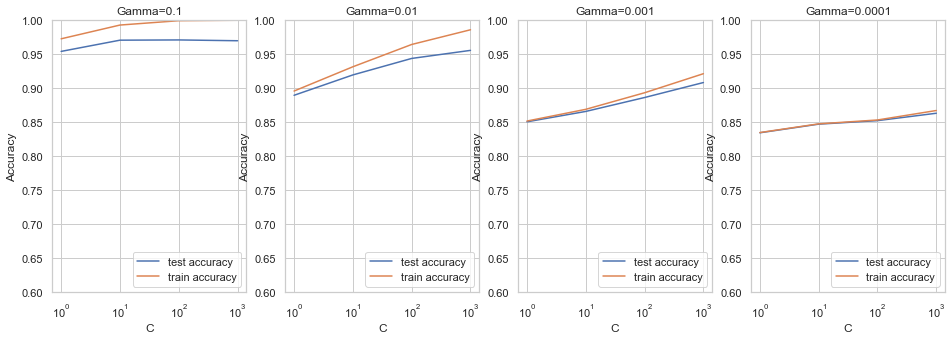

In [121]:
# cv results
svm_cv_results = pd.DataFrame(model_cv_svm.cv_results_)
svm_cv_results['param_C'] = svm_cv_results['param_C'].astype('int')
gamma=[1e-1,1e-2, 1e-3, 1e-4]
plt.figure(figsize=(16,5))
plt.subplot(141)
display_hyper_stats(svm_cv_results,gamma[0])
plt.subplot(142)
display_hyper_stats(svm_cv_results,gamma[1])
plt.subplot(143)
display_hyper_stats(svm_cv_results,gamma[2])
plt.subplot(144)
display_hyper_stats(svm_cv_results,gamma[3])
plt.show()

> <span style='color:blue'>**Analysis:** The plots above show some useful insights:
>> - Non-linear models (high gamma) perform *much better* than the linear ones
>> - At any value of gamma, a high value of C leads to better performance
>> - Model with gamma = 0.1 tends to overfit and rest of the values seems to be good. 
>> - This suggests that the problem and the data is **inherently non-linear** in nature, and a complex model will outperform simple, linear models in this case.</span>

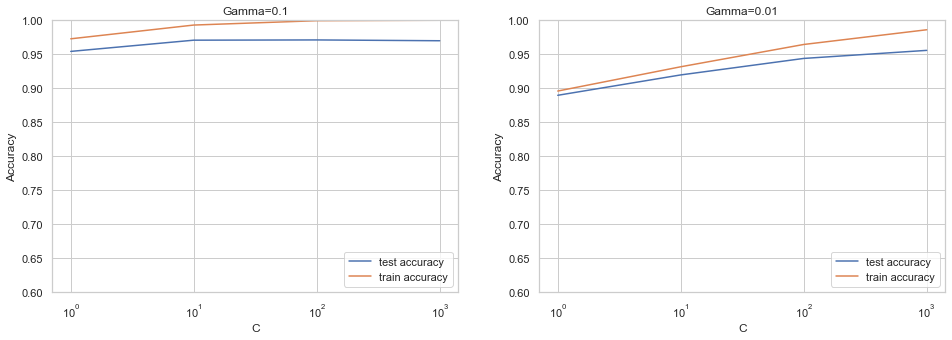

In [122]:
plt.figure(figsize=(16,5))
plt.subplot(121)
display_hyper_stats(svm_cv_results,gamma[0])
plt.subplot(122)
display_hyper_stats(svm_cv_results,gamma[1])

In [123]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv_svm.best_score_
best_hyperparams = model_cv_svm.best_params_

log("The best test score is {0} corresponding to hyperparameters {1}".format(round(best_score,2), best_hyperparams))

> <span style='color:black'>The best test score is 0.97 corresponding to hyperparameters {'C': 100, 'gamma': 0.1}</span>

> <span style='color:blue'>**Analysis:** The plots above show some useful insights:<br>
- Looking at above curves and values , model with gamma=0.1 seems to be overfitting and should not be used.<br>
- Model selected with best value as 'C': 100, 'gamma': 0.1 but this model also seems to be overfitting<br>
- But model selected with value 'C': 10, 'gamma': 0.1 should produce better results.<br>
- We will be selecting these values for final modelling.<br>
</span>

> ### Building and Evaluating the Final Model
- Let's now build and evaluate the final model, i.e. the model with highest test accuracy.

In [124]:
# model with optimal hyperparameters
final_svm_model = svm.SVC(C=10, gamma=0.1, kernel="rbf",probability=True)

final_svm_model.fit(x_train, y_train)

y_pred = final_svm_model.predict(x_test)

# metrics
log("Max accuracy with SVM (rbf) is "+str(round(metrics.accuracy_score(y_test, y_pred),2)))

> <span style='color:black'>Max accuracy with SVM (rbf) is 0.92</span>

------ 

### SVM( rfb ) [Hyper] Model Stats Scores Summary : 

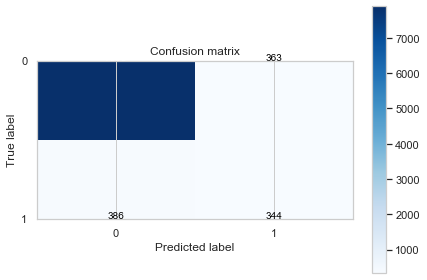

,Model,Accuracy,Precision,Recall,AUC,F1
0,SVM( rfb ) [Hyper],0.92,0.47,0.49,0.71,0.48


In [125]:
print_model_metrics(y_test, y_pred,"SVM( rfb ) [Hyper]")

## <a id='5.3'>5.3. Tree Model Regression</a> 

> Let's first fit a random forest model with default hyperparameters.

In [126]:
telecom_tree_df = telecom_df_final.copy()

In [127]:
x_train, x_test, y_train, y_test = get_regression_data(telecom_tree_df)

> <span style='color:black'>Scaling the data ....</span>

> <span style='color:black'>Shape of train datatset before : (20967, 79)</span>

> <span style='color:black'>Percenatge of Churned customer data : 8.12</span>

> <span style='color:black'>Applying SMOTE to normalize imbalance ....</span>

> <span style='color:black'>Shape of train datatset after SMOTE : (38528, 79)</span>

> <span style='color:black'>Shape of train datatset after PCA : (38528, 60)</span>

In [128]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

In [129]:
rfc = RandomForestClassifier()
rfc.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [130]:
# Making predictions
predictions = rfc.predict(x_test)

------ 

### RandomForest (Default) Model Stats Scores Summary : 

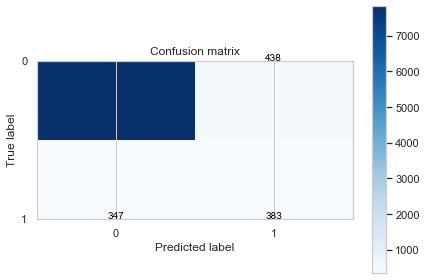

,Model,Accuracy,Precision,Recall,AUC,F1
0,RandomForest (Default),0.91,0.52,0.47,0.74,0.49


In [131]:
print_model_metrics(y_test,predictions,"RandomForest (Default)")

> <span style='color:blue'>**Analysis:**
-    So far so good, let's now look at the list of hyperparameters which we can tune to improve model performance.

> ### Hyperparameter Tuning

In [132]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold,GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report


def tune_hyperparameter(parameters,x_train,y_train,n_folds = 5,max_depth=0):
    
    if(max_depth==0):
        rf = RandomForestClassifier()
    else :
        rf = RandomForestClassifier(max_depth=max_depth)
        
    rf = GridSearchCV(rf, parameters, cv=n_folds,n_jobs = -1, scoring="accuracy",return_train_score=True)
    rf.fit(x_train, y_train)
    scores = rf.cv_results_

    for key in parameters.keys():
        hyperparameters = key
        break

    # plotting accuracies for parameters
    plt.figure(figsize=(16,5))
    plt.plot(scores["param_"+hyperparameters], scores["mean_train_score"], label="training accuracy")
    plt.plot(scores["param_"+hyperparameters], scores["mean_test_score"], label="test accuracy")
    plt.xlabel(hyperparameters)
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

> #### Tuning max_depth
Let's try to find the optimum values for ```max_depth``` and understand how the value of max_depth impacts the overall accuracy of the ensemble.


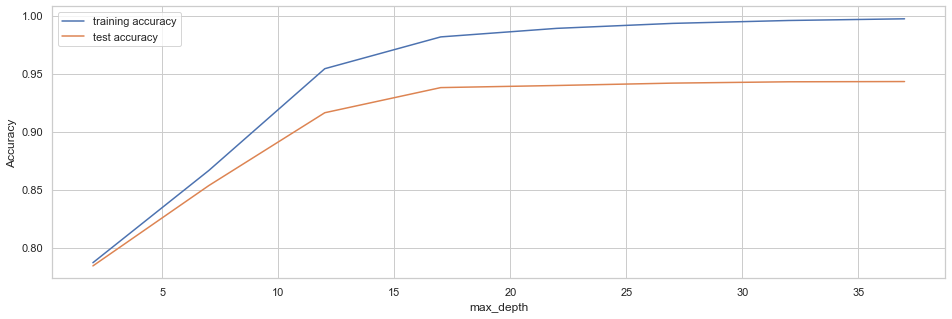

In [133]:
# parameters to build the model on
parameters = {'max_depth': range(2, 40, 5)}
tune_hyperparameter(parameters,x_train,y_train)

> <span style='color:blue'>**Analysis:**
-    We can see that as we increase the value of max_depth, both train and test scores increase till a point, but after that test score becomme stagnant. The ensemble tries to overfit as we increase the max_depth. Thus, controlling the depth of the constituent trees will help reduce overfitting in the forest. **12 and 18** value have peek convergens and can be used for grid veiw search.

> #### Tuning n_estimators
- Let's try to find the optimum values for n_estimators and understand how the value of n_estimators impacts the overall accuracy. Notice that we'll specify an appropriately low value of max_depth, so that the trees do not overfit.
<br>

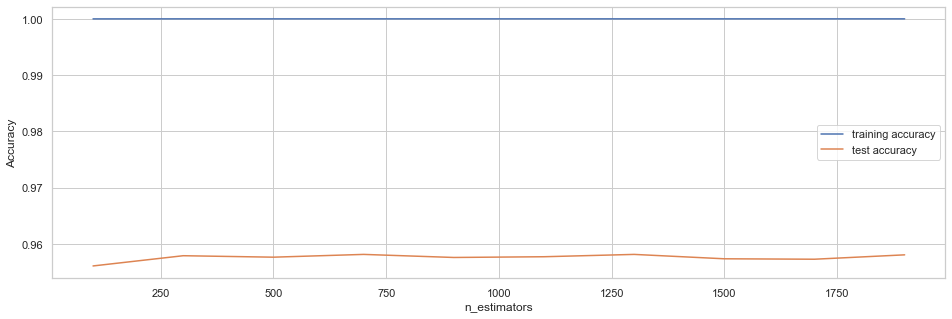

In [134]:
# parameters to build the model on
parameters = {'n_estimators': range(100, 2000, 200)}
tune_hyperparameter(parameters,x_train,y_train)

> <span style='color:blue'>**Analysis:** :  
-    Score almost remain the same with very low dip throught the range. We will use **200** for grid view search.

> #### Tuning max_features
- Let's see how the model performance varies with ```max_features```, which is the maximum numbre of features considered for splitting at a node.

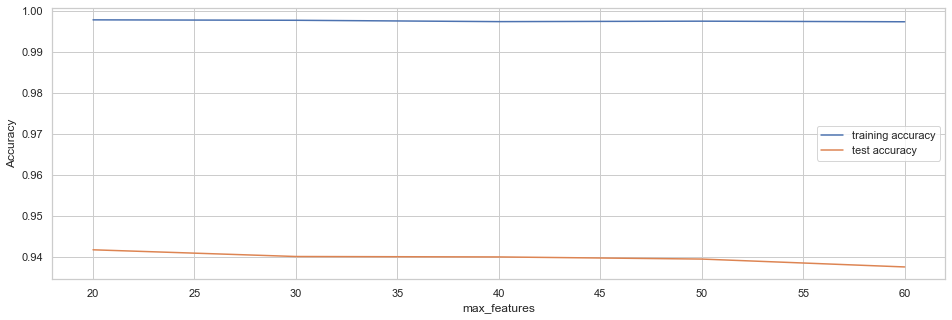

In [135]:
# parameters to build the model on
parameters = {'max_features': [20,30,40,50,60]}
tune_hyperparameter(parameters,x_train,y_train,4)

> <span style='color:blue'>**Analysis:** 
-    Apparently, accuracy of training seems to be stable and test scores seems to increase till **30** and then decrease. Again we see increase on **40** and we will use that.

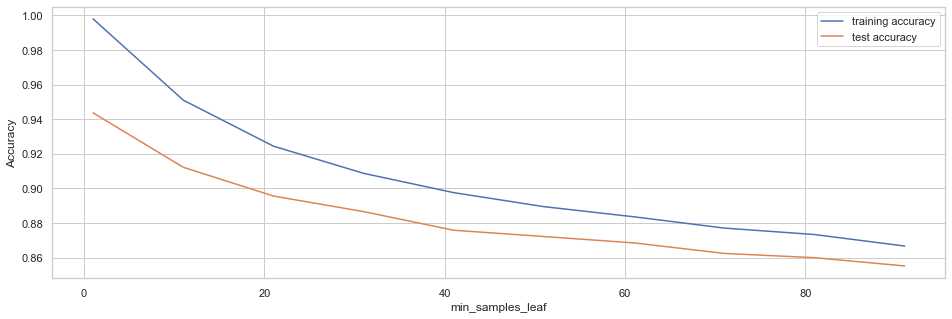

In [136]:
# parameters to build the model on
parameters = {'min_samples_leaf': range(1, 100, 10)}
tune_hyperparameter(parameters,x_train,y_train)

> <span style='color:blue'>**Analysis:**
-    We can see that the model starts to overfit as value is decrease the value of min_samples_leaf. **10 to 20** seems to be a good range and that will be used in grid search.

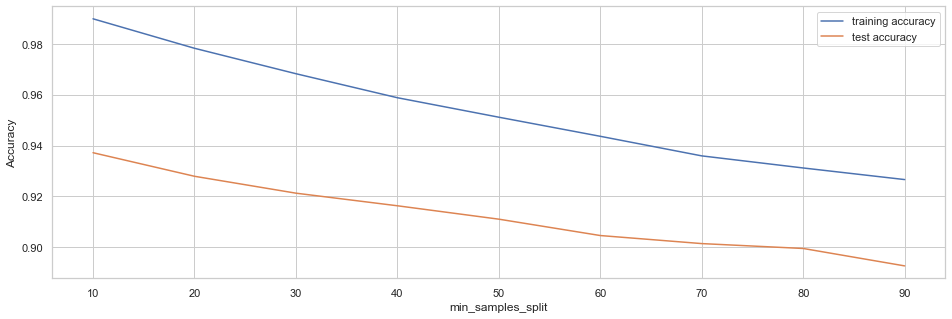

In [137]:
# parameters to build the model on
parameters = {'min_samples_split': range(10, 100, 10)}
tune_hyperparameter(parameters,x_train,y_train)

> <span style='color:blue'>**Analysis:** 
-    Range **10 to 30** is optimal with good accuracy. 

> #### Grid Search to Find Optimal Hyperparameters
- We can now find the optimal hyperparameters using GridSearchCV.

In [138]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [12,18],
    'n_estimators': [200],
    'max_features': [40],
    'min_samples_leaf': [10,20],
    'min_samples_split': [10,20,30]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
rf_grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1,verbose = 1,return_train_score=True)

In [139]:
# Fit the grid search to the data
rf_grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 47.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 73.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [140]:
# printing the optimal accuracy score and hyperparameters
log('We can get accuracy of '+str(round(rf_grid_search.best_score_,2))+' using '+str(rf_grid_search.best_params_))

> <span style='color:black'>We can get accuracy of 0.93 using {'max_depth': 18, 'max_features': 40, 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 200}</span>

In [141]:
log("Max accuracy with Random Forest classifier - "+str(round(rf_grid_search.best_score_,2)))

> <span style='color:black'>Max accuracy with Random Forest classifier - 0.93</span>

> ### Building and Evaluating the Final Model for Random Forest
- Let's now build and evaluate the final model, i.e. the model with highest test accuracy.

In [142]:
rfc = RandomForestClassifier(max_depth=18,
                             max_features=40,
                             min_samples_leaf=10,
                             min_samples_split=20,
                             n_estimators=200,
                             n_jobs = -1)
rfc.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=18, max_features=40, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [143]:
# Making predictions
predictions = rfc.predict(x_test)

------ 

### RandomForest (Hyper) Model Stats Scores Summary : 

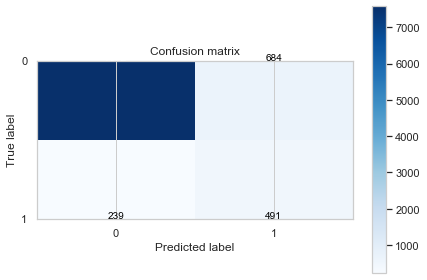

,Model,Accuracy,Precision,Recall,AUC,F1
0,RandomForest (Hyper),0.90,0.67,0.42,0.79,0.52


In [144]:
# Printing confusion matrix
print_model_metrics(y_test,predictions,'RandomForest (Hyper)')

## <a id='5.4'>5.4. XGBoost</a>
Let's finally try XGBoost. The hyperparameters are the same, some important ones being ```subsample```, ```learning_rate```, ```max_depth``` etc.


In [145]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from imblearn.over_sampling import SMOTE

In [146]:
telecom_xgboost_df = telecom_df_final.copy()
x_train, x_test, y_train, y_test = get_regression_data(telecom_xgboost_df)

> <span style='color:black'>Scaling the data ....</span>

> <span style='color:black'>Shape of train datatset before : (20967, 79)</span>

> <span style='color:black'>Percenatge of Churned customer data : 8.12</span>

> <span style='color:black'>Applying SMOTE to normalize imbalance ....</span>

> <span style='color:black'>Shape of train datatset after SMOTE : (38528, 79)</span>

> <span style='color:black'>Shape of train datatset after PCA : (38528, 60)</span>

In [147]:
# fit model on training data with default hyperparameters
model = XGBClassifier()
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [148]:
# evaluate predictions
y_pred = model.predict(x_test)

------ 

### XGBoost (Default) Model Stats Scores Summary : 

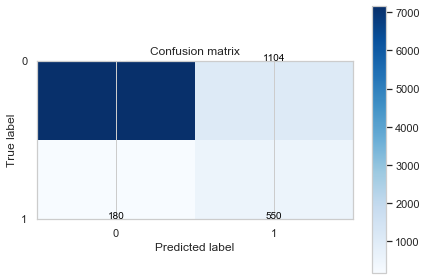

,Model,Accuracy,Precision,Recall,AUC,F1
0,XGBoost (Default),0.86,0.75,0.33,0.81,0.46


In [149]:
print_model_metrics(y_test, y_pred ,'XGBoost (Default)')

> <span style='color:blue'>**Analysis:** 
-    The roc_auc in this case is about 85% with default hyperparameters.


Let's now try tuning the hyperparameters using k-fold CV. We'll then use grid search CV to find the optimal values of hyperparameters.

In [150]:
# hyperparameter tuning with XGBoost

# creating a KFold object 
folds = 5

# specify range of hyperparameters
param_grid = {'learning_rate': [0.1,0.2,0.3], 
             'subsample': [0.3,0.4,0.5]}          


# specify model
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'accuracy', # accuracy
                        cv = folds, 
                        n_jobs = -1,
                        verbose = 1,
                        return_train_score=True)      



In [151]:
# fit the model
model_cv.fit(x_train, y_train)       

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  4.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=2, min_child_weight=1,
                                     missing=None, n_estimators=200, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'subsample': [0.3, 0.4, 0.5]},
             pre_dispatch='2*n_jobs', refit=True, retu

In [152]:
# cv results
cv_results_xboost = pd.DataFrame(model_cv.cv_results_)
cv_results_xboost['param_learning_rate'] = cv_results_xboost['param_learning_rate'].astype('float')

In [153]:
# printing the optimal accuracy score and hyperparameters
log('We can get accuracy of **'+str(round(model_cv.best_score_,2))+'** using '+str(model_cv.best_params_))

> <span style='color:black'>We can get accuracy of **0.88** using {'learning_rate': 0.3, 'subsample': 0.5}</span>

In [154]:
def plot_for_xboost(param_grid,cv_results):
    plt.figure(figsize=(18,5))
    for n, subsample in enumerate(param_grid['subsample']):
        # subplot 1/n
        plt.subplot(1,len(param_grid['subsample']), n+1)
        df = cv_results[cv_results['param_subsample']==subsample]

        plt.plot(df["param_learning_rate"], df["mean_test_score"])
        plt.plot(df["param_learning_rate"], df["mean_train_score"])
        plt.xlabel('learning_rate')
        plt.ylabel('AUC')
        plt.title("subsample={0}".format(subsample))
        plt.ylim([0.60, 1])
        plt.legend(['test score', 'train score'], loc='right left')
        plt.xscale('log')

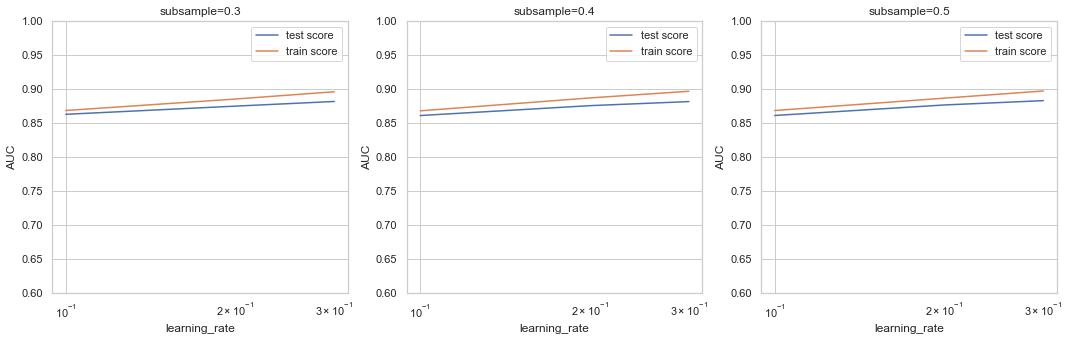

In [155]:
param_grid1 = {'learning_rate': [0.1,0.2,0.3], 'subsample': [0.3,0.4,0.5]}  
plot_for_xboost(param_grid1,cv_results_xboost)


> <span style='color:blue'>**Analysis:** 
-    The results show that a subsample size of **0.5** and learning_rate of about **0.3** seems optimal. 
Also, XGBoost has resulted in the highest ROC AUC obtained (across various hyperparameters). 

> Let's build a final model with the chosen hyperparameters.

In [156]:
# chosen hyperparameters
# 'objective':'binary:logistic' outputs probability rather than label, which we need for auc
params = {'learning_rate': 0.3,
          'max_depth': 2, 
          'n_estimators':200,
          'subsample':0.5,
         'objective':'binary:logistic'}

# fit model on training data
model_XGB = XGBClassifier(params = params,max_depth=2, n_estimators=200)
model_XGB.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic',
              params={'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 200,
                      'objective': 'binary:logistic', 'subsample': 0.5},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [157]:
# predict
y_pred = model_XGB.predict(x_test)

------ 

### XGBoost (Hyper Tuned) Model Stats Scores Summary : 

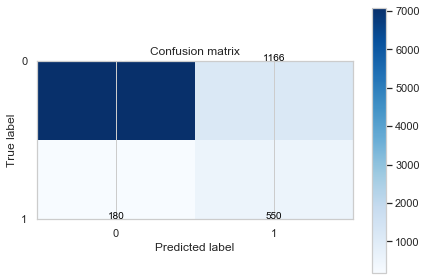

,Model,Accuracy,Precision,Recall,AUC,F1
0,XGBoost (Hyper Tuned),0.85,0.75,0.32,0.81,0.45


In [158]:
print_model_metrics(y_test, y_pred,'XGBoost (Hyper Tuned)')

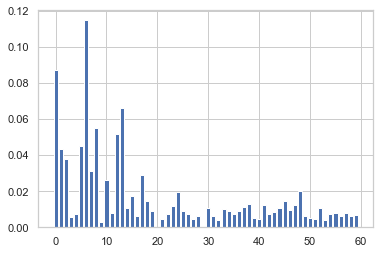

In [159]:
# plot
plt.bar(range(len(model.feature_importances_)), model_XGB.feature_importances_)
plt.show()

------ 

### Important features ...

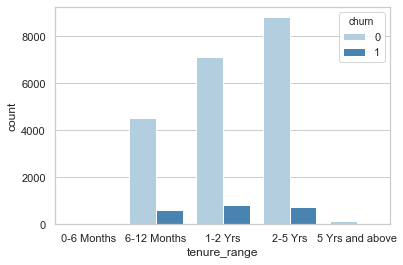

,PC1,PC2,PC3,Feature
0,0.00,0.29,0.15,arpu_8
1,-0.11,0.11,0.15,onnet_mou_8
2,-0.10,0.20,0.11,offnet_mou_8
3,-0.01,0.05,0.01,roam_ic_mou_8
4,-0.02,0.07,0.03,roam_og_mou_8
5,-0.03,0.10,0.02,loc_og_t2t_mou_8
6,-0.03,0.18,-0.03,loc_og_t2m_mou_8
7,0.01,0.11,-0.09,loc_og_t2f_mou_8
8,-0.01,0.02,0.08,loc_og_t2c_mou_8
9,-0.11,0.07,0.16,std_og_t2t_mou_8


In [160]:
header("Important features ...")
plt.figure(figsize=(6,4))
sns.countplot(x = 'tenure_range', hue = 'churn',data = tenure_data,palette=("Blues"))
plt.show()


col = list(X_scaled.columns)
df_pca = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'PC3':pca.components_[2],'Feature':col})
df_pca.head(15)

# <a id='6'>6. Model Performances</a>
## <a id='6.1'>6.1. model performance metrics</a>

In [161]:
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

#gives model report in dataframe
def model_report(model,training_x,testing_x,training_y,testing_y,name) :
    model.fit(training_x,training_y)
    predictions  = model.predict(testing_x)
    accuracy     = accuracy_score(testing_y,predictions)
    recallscore  = recall_score(testing_y,predictions)
    precision    = precision_score(testing_y,predictions)
    roc_auc      = roc_auc_score(testing_y,predictions)
    f1score      = f1_score(testing_y,predictions) 
    kappa_metric = cohen_kappa_score(testing_y,predictions)
    
    df = pd.DataFrame({"Model"           : [name],
                       "Accuracy_score"  : [accuracy],
                       "Recall_score"    : [recallscore],
                       "Precision"       : [precision],
                       "f1_score"        : [f1score],
                       "Area_under_curve": [roc_auc],
                       "Kappa_metric"    : [kappa_metric],
                      })
    return df

#outputs for every model
model1 = model_report(model_LR,x_train,x_test,y_train,y_test,
                      "Logistic Regression")
model2 = model_report(final_svm_model,x_train,x_test,y_train,y_test,
                      "SVM Model")
model3 = model_report(rfc,x_train,x_test,y_train,y_test,
                      "Random Forest")
model4 = model_report(model_XGB,x_train,x_test,y_train,y_test,
                      "XGBoost Classifier")

#concat all models
model_performances = pd.concat([model1,model2,model3,model4],axis = 0).reset_index()

model_performances = model_performances.drop(columns = "index",axis =1)

table  = ff.create_table(np.round(model_performances,4))

py.iplot(table)

## <a id='6.2'>6.2. Compare model metrics</a>

In [162]:
model_performances
def output_tracer(metric,color) :
    tracer = go.Bar(y = model_performances["Model"] ,
                    x = model_performances[metric],
                    orientation = "h",name = metric ,
                    marker = dict(line = dict(width =.7),
                                  color = color)
                   )
    return tracer

layout = go.Layout(dict(title = "Model performances",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "metric",
                                     zerolinewidth=1,
                                     ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        margin = dict(l = 250),
                        height = 780
                       )
                  )


trace1  = output_tracer("Accuracy_score","#6699FF")
trace2  = output_tracer('Recall_score',"red")
trace3  = output_tracer('Precision',"#33CC99")
trace4  = output_tracer('f1_score',"lightgrey")
trace5  = output_tracer('Kappa_metric',"#FFCC99")

data = [trace1,trace2,trace3,trace4,trace5]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

## <a id='6.3'>6.3. Confusion matrices for models</a>

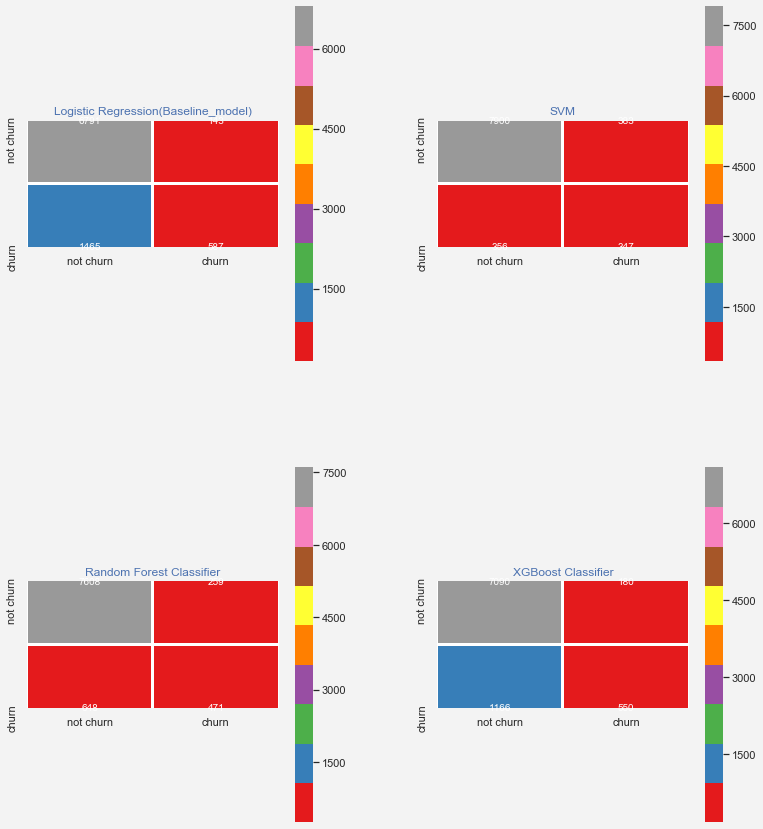

In [163]:
lst    = [model_LR,final_svm_model,rfc,model_XGB]
          
length = len(lst)

mods   = ['Logistic Regression(Baseline_model)','SVM',
          'Random Forest Classifier',
          'XGBoost Classifier']

fig = plt.figure(figsize=(13,15))
fig.set_facecolor("#F3F3F3")
for i,j,k in itertools.zip_longest(lst,range(length),mods) :
    plt.subplot(2,2,j+1)
    predictions = i.predict(x_test)
    conf_matrix = confusion_matrix(predictions,y_test)
    sns.heatmap(conf_matrix,annot=True,fmt = "d",square = True,
                xticklabels=["not churn","churn"],
                yticklabels=["not churn","churn"],
                linewidths = 2,linecolor = "w",cmap = "Set1")
    plt.title(k,color = "b")
    plt.subplots_adjust(wspace = .3,hspace = .3)

## <a id='6.4'>6.4. ROC - Curves  for models</a>

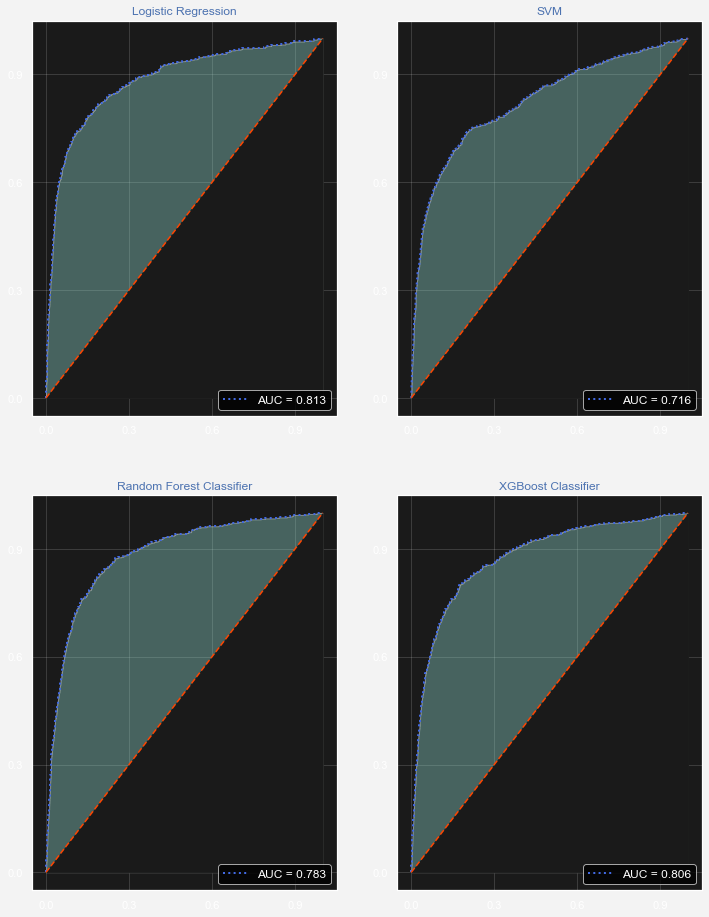

In [164]:
lst    = [model_LR,final_svm_model,rfc,model_XGB]

length = len(lst)

mods   = ['Logistic Regression','SVM',
          'Random Forest Classifier',
          'XGBoost Classifier']

plt.style.use("dark_background")
fig = plt.figure(figsize=(12,16))
fig.set_facecolor("#F3F3F3")
for i,j,k in itertools.zip_longest(lst,range(length),mods) :
    qx = plt.subplot(2,2,j+1)
    probabilities = i.predict_proba(x_test)
    predictions   = i.predict(x_test)
    fpr,tpr,thresholds = roc_curve(y_test,probabilities[:,1])
    plt.plot(fpr,tpr,linestyle = "dotted",
             color = "royalblue",linewidth = 2,
             label = "AUC = " + str(np.around(roc_auc_score(y_test,predictions),3)))
    plt.plot([0,1],[0,1],linestyle = "dashed",
             color = "orangered",linewidth = 1.5)
    plt.fill_between(fpr,tpr,alpha = .4)
    plt.fill_between([0,1],[0,1],color = "k")
    plt.legend(loc = "lower right",
               prop = {"size" : 12})
    qx.set_facecolor("k")
    plt.grid(True,alpha = .15)
    plt.title(k,color = "b")
    plt.xticks(np.arange(0,1,.3))
    plt.yticks(np.arange(0,1,.3))

## <a id='6.5'>6.5. Precision recall curves</a>

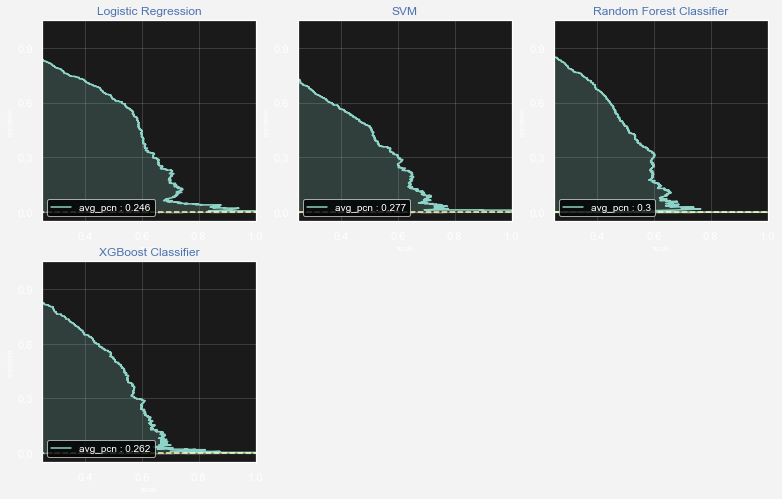

In [165]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score


lst    = [model_LR,final_svm_model,rfc,model_XGB]

length = len(lst)

mods   = ['Logistic Regression','SVM',
          'Random Forest Classifier',
          'XGBoost Classifier']

fig = plt.figure(figsize=(13,17))
fig.set_facecolor("#F3F3F3")
for i,j,k in itertools.zip_longest(lst,range(length),mods) :
    
    qx = plt.subplot(4,3,j+1)
    probabilities = i.predict_proba(x_test)
    predictions   = i.predict(x_test)
    recall,precision,thresholds = precision_recall_curve(y_test,probabilities[:,1])
    plt.plot(recall,precision,linewidth = 1.5,
             label = ("avg_pcn : " + 
                      str(np.around(average_precision_score(y_test,predictions),3))))
    plt.plot([0,1],[0,0],linestyle = "dashed")
    plt.fill_between(recall,precision,alpha = .2)
    plt.legend(loc = "lower left",
               prop = {"size" : 10})
    qx.set_facecolor("k")
    plt.grid(True,alpha = .15)
    plt.title(k,color = "b")
    plt.xlabel("recall",fontsize =7)
    plt.ylabel("precision",fontsize =7)
    plt.xlim([0.25,1])
    plt.yticks(np.arange(0,1,.3))

## <a id='7'>7. Recommendations</a>

### Business Insights 


-    Less number of **high value customer** are churing but for last **6 month** no new high valued cusotmer is onboarded which is concerning and company should concentrate on that aspect. 

- Customers with less than **4 years** of tenure are more likely to churn and company should concentrate more on that segment by rolling out new schems to that group. 

- **Average revenue per user** seems to be most important feature in determining churn prediction. 

- **Incoming** and **Outgoing Calls** on **romaing** for 8th month are strong indicators of churn behaviour

- **Local Outgoing calls** made to landline , fixedline , mobile and call center provides a strong indicator of churn behaviour.  

- Better 2G/3G area coverage where 2G/3G services are not good, it's strong indicator of churn behaviour.

> ### Model Insights 

In [166]:
consolidate_summary.head(10)

,Model,Accuracy,Precision,Recall,AUC,F1
0,SVM (Default)-linear,0.83,0.80,0.30,0.82,0.44
1,SVM (Default)-rbf,0.87,0.75,0.36,0.82,0.49
2,SVM( rfb ) [Hyper],0.92,0.47,0.49,0.71,0.48
3,RandomForest (Default),0.91,0.52,0.47,0.74,0.49
4,RandomForest (Hyper),0.90,0.67,0.42,0.79,0.52
5,XGBoost (Default),0.86,0.75,0.33,0.81,0.46
6,XGBoost (Hyper Tuned),0.85,0.75,0.32,0.81,0.45


- **SVM** with tuned hyperparameters produce best result on this dataset with 0.92 accuracy.

- **Random forest** also produce good accuracy with 0.91 (default overfit model) and 0.90 with tuned hyperparameters.

- **XGBoost** also produce apt accuracy of 0.86 (default overfit model) and 0.85 with tuned hyperparameters.

- **As per our analysis SVM and Random forest produce best accuracy and models can be selected to predict churn data for future dataset or production.**